# Applying Gaussian process models to Hippocampal grid cell data

M. Rule, May 5 2020 to January 8 2021

[Gaussian Processes (GPs)](https://en.wikipedia.org/wiki/Gaussian_process) generalize the idea of multivariate Gaussian distributions to distributions over functions. They are useful in neural data analysis, since they let us estimate how the firing rate of a neuron varies as a function of other variables (e.g. to [track retinal waves](https://mrule-intheworks.blogspot.com/2019/02/neural-field-models-for-latent-state.html)). Lately, we've been using Gaussian processes to describe the firing rate map of [hippocampal grid cells](https://en.wikipedia.org/wiki/Grid_cell). 

These notes briefly review Bayesian inference and Gaussian processes. We then explore applications of Gaussian Process methods to analyzing grid cell data, eventually constructing a GP model of the log-rate that accounts for the Poisson noise in spike count data. Along the way, we also discuss fast approximations for these methods, like [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation), or approximating GP inference using convolutions. 

# Introduction

First, we briefly review Bayesian inference for multivariate Gaussian variables and Gaussian processes. Then, we construct some synthetic spike-count observations, similar to what can be seen in Hippocampal grid cells. We then review how to estimate the underlying firing rate map using kernel density estimation, and discuss some regularization choices when data are limited. 

## Recall: Bayesian inference in multivariate Gaussian distributions

Loosely, Gaussian processes can be viewed as "really big" multivariate Gaussian distributions, with infinitely many variables. It's helpful to review Bayesian inference for multivariate Gaussian variables before continuing. 

Consider estimating some jointly Gaussian variables $z$ from observations $y$. Bayes' rule states that the posterior distribution $\Pr(z|y)$ is proportional to our prior, $\Pr(z)$, times the likelihood of observing $y$ given $z$, $\Pr(y|z)$:

$$
\Pr(z|y) \propto \Pr(y|z) \Pr(z).
$$

Consider a case where both $\Pr(y|z)$ and $\Pr(z)$ are Gaussian:

$$
\begin{aligned}
\Pr(z) &= \mathcal N( \mu_0, \Sigma_0 )
\\
\Pr(z|y) &= \mathcal N( y,  \Sigma_\epsilon )
\end{aligned}
$$

We can estimate $\Pr(z|y)$ using Bayes' rule, by multiplying these two probability distributions (and normalizing the result to integrate to one). This product of two multivariate Gaussian distributions is also a multivariate Gaussian distribution, $\hat z \sim \mathcal N(\mu, \Sigma)$. Its mean and covariance can be calculated as: 

\begin{equation}
\begin{aligned}
\Sigma 
&= \left[\Sigma_0^{-1} + \Sigma_\epsilon^{-1}  \right]^{-1}
\\
\mu
&= \Sigma \left[\Sigma_0^{-1}\mu_0 + \Sigma_\epsilon^{-1}y \right] 
\end{aligned}
\end{equation}

In other textbooks or tutorials, you might also see this written as 

$$
\begin{aligned}
\Sigma 
&= \Sigma_0 - \Sigma_0[\Sigma_0 + \Sigma_\epsilon]^{-1} \Sigma_0
\\
\mu
&= \mu_0 
+ \Sigma_0\left[\Sigma_\epsilon + \Sigma_0 \right]^{-1}(y-\mu_0).
\\
\end{aligned}
$$

Both forms are equivalent, and are related to each other by applying the [Sherman–Morrison–Woodbury matrix inversion lemma](https://en.wikipedia.org/wiki/Woodbury_matrix_identity). 

Sometimes one form or the other is more numerically accurate. In this work $\Sigma_0$ is sometimes poorly conditioned. For example, the prior might have small eigenvalues for the high spatial frequency components, reflecting the constraint that inferred rate maps should be smooth. In the optimized version of GP regression developed here, we include points in the measurement that have no data. This makes the observation error matrix $\Sigma_\epsilon$ undefined. However, the inverse $\Sigma_\epsilon^{-1}$ (called the precision matrix) is well defined, since we can set the precision of regions with missing data to zero. We therefore work with the following form for numerical stability:

\begin{equation}
\begin{aligned}
\Sigma 
&= \left[\Sigma_0\Sigma_\epsilon^{-1}+I\right]^{-1}\Sigma_0
\\
\mu
&= \left[\Sigma_0\Sigma_\epsilon^{-1}+I\right]^{-1}\left[\Sigma_0\Sigma_\epsilon^{-1}y+\mu_0\right] 
\end{aligned}
\end{equation}

## Recall: Gaussian process regression

Gaussian processes are commonly used to estimate a smooth underlying trend from noisy observations. [Reter Roelants'](https://peterroelants.github.io/posts/gaussian-process-tutorial/) notes on Gaussian processes is a clear and detailed introduction. 

Consider a GP regression problem for learning $y=f(\mathbf x)$, where $\mathbf x=\{x_1,x_2\}$ are coordinates in 2D. Here, our prior over functions is specified not by a mean and covariance, but by a mean function $m(\mathbf x)$ and a two-point correlation function $k(\mathbf x,\mathbf x')$, called a kernel. This might sound a bit fancy, but these are just functions that we can pass a set of points to to generate a mean vector and covariance matrix.

For the regression problem, we'd like learn a model of $y=f(\mathbf x)$ given some initial data $(x_a,y_a)$. GP regression build a posterior distribution over possible functions $f(\mathbf x)$, given our prior (mean and kernel), and these observations. For any finite collection of inputs $x_b$, we can evaluate the GP posterior $y_b = f(\mathbf x_b)$ at a specified (also finite) set of desired output points to get a posterior mean and covariance of $y_b$.

$$
\begin{aligned}
y_b &\sim \mathcal N(\mu,\Sigma)
\\
\mu &= \mu_b + \Sigma_{ab}^\top[\Sigma_{aa}+\Sigma_{\epsilon}]^{-1} (y_1 - \mu_1)
\\
\Sigma &= \Sigma_{bb} - \Sigma_{ab}^\top [\Sigma_{aa}+\Sigma_{\epsilon}]^{-1} \Sigma_{ab},
\end{aligned}
$$

where the means and covariances are computed according to the prior mean and kernel, $\mu_i{=}m(\mathbf x_i)$ and $\sigma_{ij}{=}\kappa(\mathbf x_i,\mathbf x_j)$, respectively. The observation noise model $\Sigma_{\epsilon}$ is typically assumed to be i.i.d. Gaussian noise with variance $\xi^2$, i.e. $\Sigma_{\epsilon} = \xi^2 I$, although this need not be the case. 

To connect GP regression to the Bayesian update for multivariate normal variables, consider sampling both the data and the posterior over the same a fixed set of points $x$, i.e. $x_a = x_b = x_0$. In this case, $\mu_a = \mu_b = \mu_0$ and $\Sigma_{aa} = \Sigma_{ab} = \Sigma_{bb} = \Sigma_0$, and the GP regression simplifies to:

$$
\begin{aligned}
\Sigma &= \Sigma_0 - \Sigma_0 [\Sigma_0+\Sigma_{\epsilon}]^{-1} \Sigma_0
\\
\mu 
&= \mu_0 + \Sigma_0[\Sigma_0+\Sigma_{\epsilon}]^{-1} (y_1 - \mu_0),
\end{aligned}
$$

This is identical to the posterior distribution for a multivariate Gaussian model we discussed earlier. Indeed, if your data consist of Gaussian observations over a set of points, and you evaluate the posterior at these same locations, there is no difference between Gaussian Process regression and ordinary Bayesian inference for multivariate Gaussian variables.

## Exploring Gaussian Process methods in grid cell data 

### Simulating some data

First, let's generate some fake grid cell data. We'll simulate a $L\times L$ spatial grid, and define a periodic grid-like firing intensity. Real data are always a bit messy, so we'll also model some background rate fluctuations, and non-uniform sampling of the grid (maybe the rat visits some locations more than others). 

We summarize the data in terms of two $L\times L$ arrays: $N$, which counts the number of times the rat visits each location, and $K$, which counts the total number of spikes observed in each location. Spikes are sampled as a conditionally-Poisson process with rate $\lambda$ equal to the intensity at each location. 

We also add a bit of zero padding around the data. This allows us to convolve our data with convolution kernels using circular convolution, without mixing up data from opposite ides. This will be useful later, since circular convolution can be computed very quickly using the [Fast Fourier Transform (FFT)](https://en.wikipedia.org/wiki/Fast_Fourier_transform). More generally, we might also want to mask out parts of the space if e.g. the rat was exploring an arena with something other than a square shape. 

In [1]:
%matplotlib inline
from pylab import *
mpl.rcParams['figure.figsize'] = (8,2.5)
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.cmap']='magma';

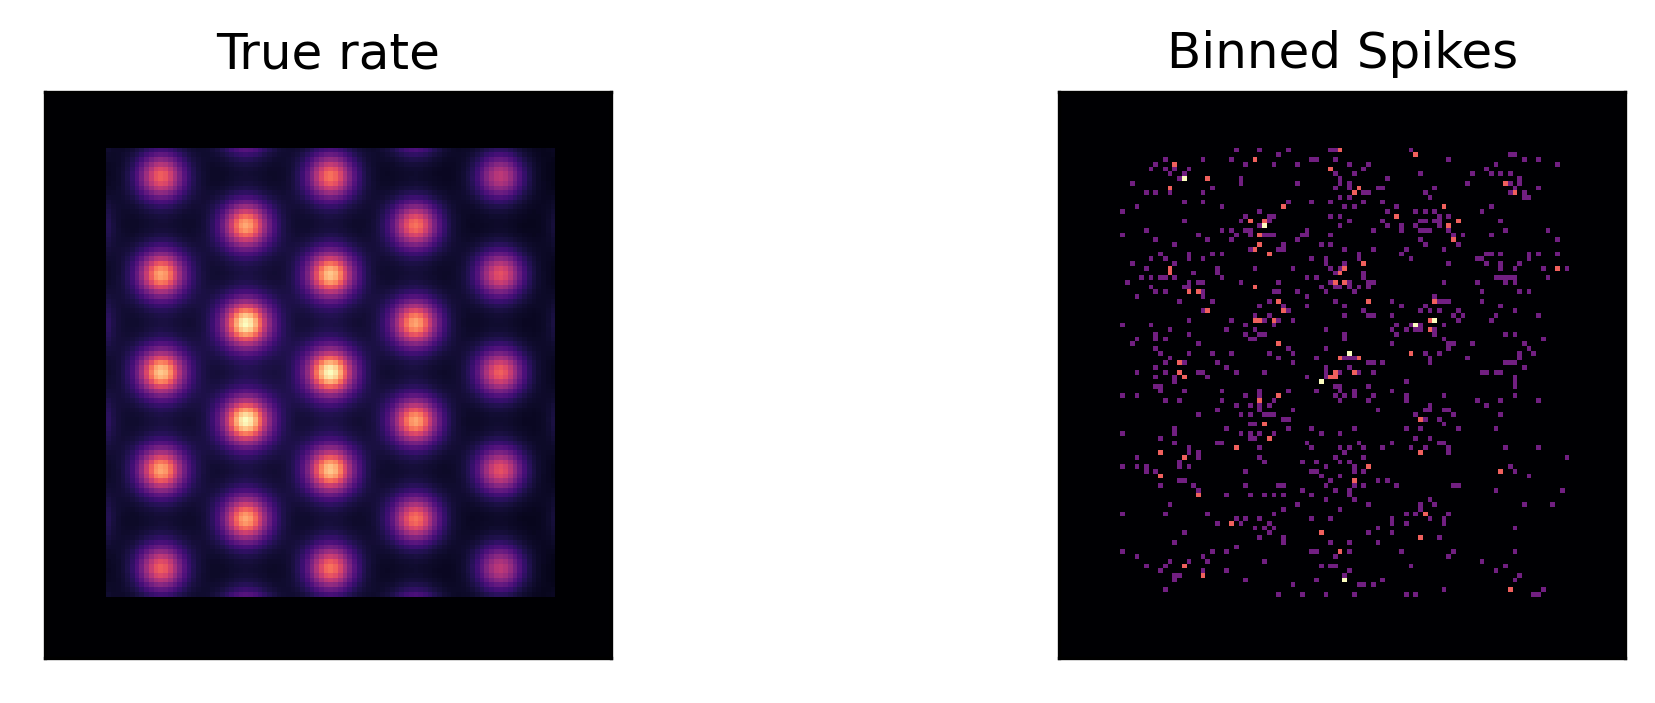

In [2]:
L = 120   # Grid size
P = 18    # Grid spacing
α = 0.5   # Grid "sharpness"
μ = 0.11  # Mean firing rate (spikes per sample)

# 2D grid coordinates as complex numbers
c = arange(L)-L//2
coords = 1j*c[:,None]+c[None,:]

def ideal_hex_grid(L,P):
    # Build a hexagonal grid by summing three cosine waves
    θs = exp(1j*array([0,pi/3,2*pi/3]))
    return sum([cos((θ*coords).real*2*pi/P) for θ in θs],0)

# Generate intensity map: Exponentiate and scale mean rate
λ0 = exp(ideal_hex_grid(L,P)*α)
λ0 = λ0*μ/mean(λ0)

# Zero pad edges
mask = np.maximum(abs(real(coords)),abs(imag(coords)))<0.4*L
λ0 = λ0*mask

# For realism, also add some background rate changes
λ0 = λ0*(1-abs(coords/L+0.1))

# Simulated a random number of visits to each location 
# as well as Poisson spike counts at each location
N = poisson(2*(1-abs(coords/L-0.2j)),size=(L,L))*mask
K = poisson(λ0*N)

def notic():
    xticks([]); 
    yticks([]);

v1 = μ*3 # Color limits for rate
subplot(121); imshow(λ0); notic(); title('True rate')
subplot(122); imshow(K);  notic(); title('Binned Spikes');

## Estimating rate in each bin

The simplest way to estimate the rate at each location is to simply divide the number of observed spikes $K$ by the number of visits $N$ to each location. This is a very noisy estimate (below, left), and is undefined when $N$ is zero. 

$$
\hat\lambda = \frac K N 
$$

It's tempting to add a little ad-hoc regularization to handle the $N=0$ case gracefully, for example

$$
\hat\lambda = \frac{K}{N+\tfrac 1 2} 
$$

Tricks like this might seem arbitrary (and perhaps wrong), but there is a principled based on Bayesian statistics. We assume that each time the rat visits a location with intensity $\lambda$, we observe $y$ spikes, which are Poisson distributed:

$$
\Pr(y|\lambda) = \frac {\lambda^y e^{-\lambda}} {\Gamma(y+1)}
$$

This gives us a likelihood for estimating $\lambda$ given $y$. 
The [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) is the conjugate prior for Poisson rates, with shape parameter $\alpha$ and rate parameter $\beta$: 

$$
\Pr(\lambda|\alpha,\beta) = \frac{\beta^{\alpha}}{\Gamma(\alpha)} {\lambda^{\alpha-1} e^{-\beta\lambda}}.
$$

We can write the likelihood of observing a count observation $y$ given rate $\lambda$ as:

$$
\Pr(\lambda|y) \propto {\lambda^{y} e^{-\lambda}}.
$$

To combine $N$ observations $y_t\in\{y_1,..,y_T\}$, take the product of the likelihoods for each observation. This reduces to a simplified expression in terms of the total number of spikes $K=\sum_t y_t$:

$$
\begin{aligned}
\Pr(\lambda|y_1,..,y_T)&\propto \textstyle\prod_t \lambda^{y_t} e^{-\lambda}= \lambda^K e^{-N\lambda}.
\end{aligned}
$$

To assign a rate estimate to locations with missing data, we can define a Bayesian prior for $\lambda$. This regularizes bins that have limited data, reducing variance at the expense of increased bias. For regularization strength $\rho>0$, we set $\Pr(\lambda)\sim\operatorname{Gamma}(\alpha_0,\beta_0)$, with $\beta_0=\rho$ and $\alpha_0=\rho(\mu-1)+1$, and were $\mu$ is the overall average firing rate of the neuron, regardless of location. This leads to a posterior distribution of:

$$
\begin{aligned}
\Pr(\lambda|y_1,..,y_T) 
&=
\lambda^{K}e^{-N\lambda}
\cdot
[\lambda^{\alpha_0-1} e^{-\beta_0\lambda}]
\\&=
\lambda^{K+\rho(\mu-1)+1}e^{-(N+\rho)\lambda}.
\end{aligned}
$$

This gives a gamma-distributed posterior with $\alpha = K+\rho(\mu-1)+1$ and $\beta=N+\rho$. The posterior mean, $\alpha/\beta$, is a regularized estimator $\hat\lambda_\mu$ of the rate:

$$
\hat\lambda_\mu = \frac{K+\rho(\mu-1)+1}{N+\rho}.
$$

This is biased toward higher rates due the +1 in the numerator. Using the mode $(\alpha-1)/\beta$ is another option, which lacks this bias:

$$
\hat\lambda_\text{mode} = \frac{K+\rho\mu}{N+\rho}.
$$

One can interpolate between these mean-based and mode-based regularizers with another parameter $\gamma\in[0,1]$, where $\gamma=0$ corresponds to the mode-based estimator, and $\gamma=1$ to the mean-based estimator:

$$
\hat\lambda = \frac{K+\rho(\mu-\gamma)+\gamma}{N+\rho}.
$$

We use $\gamma=0.5$ and $\rho=1.3$ as the default here. 

Even with regularization, estimating the rate directly in each bin is far too noisy to be useful (below, right). Why go through all this trouble to define a principled way to regularize counts for single bins then? These regularized rate estimators provide a principled way to define how a rate estimator should behave when data are limited, and can be incorporated into better estimators that pool data from adjacent bins. Next, we explore a simple way to pool data from adjacent bins using kernel density smoothing.

K/N Estimator:
> Normalized MSE: 199.8%
> Pearson correlation: 0.21
Regularized Estimator:
> Normalized MSE: 168.5%
> Pearson correlation: 0.23


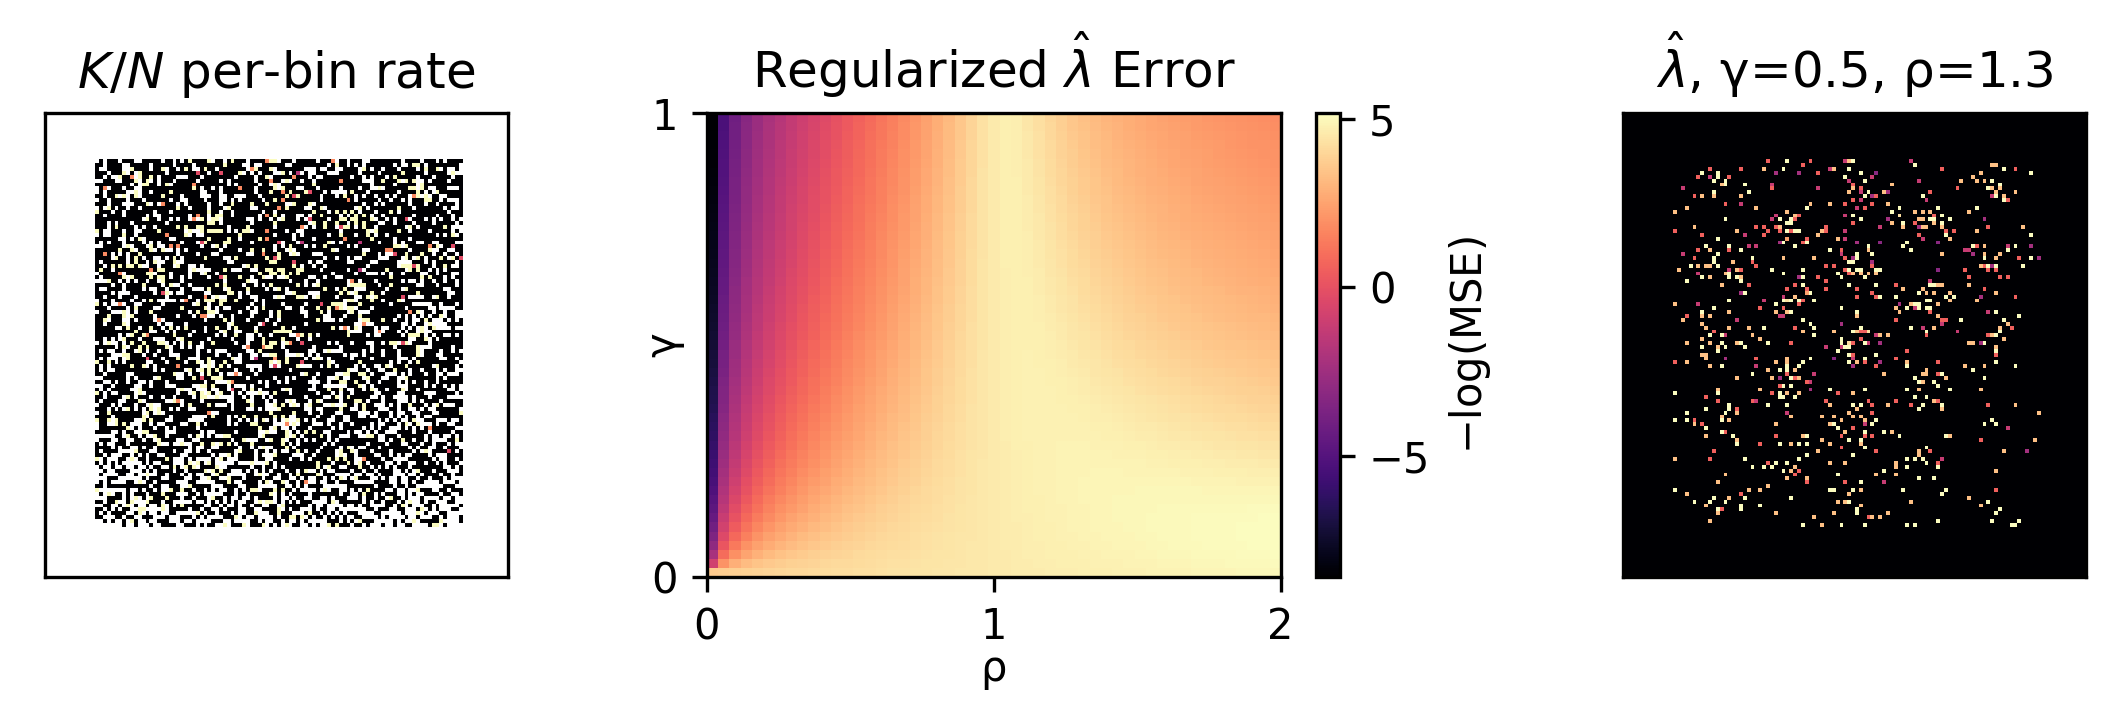

In [3]:
def regλ(N,K,ρ=1.3,γ=0.5):
    # Regularized rate estimate
    return (K+ρ*(sum(K)/sum(N)-γ)+γ)/(N+ρ)

from scipy.stats import pearsonr
def printstats(a,b,message):
    # normalized root-mean-squared error
    a,b = a[mask],b[mask]
    NMSE = mean((a-b)**2)/sqrt(mean(a**2)*mean(b**2))
    print(message+':')
    print('> Normalized MSE: %0.1f%%'%(100*NMSE))
    print('> Pearson correlation: %0.2f'%pearsonr(a,b)[0]) 

# Rate per bin using naive estimator
λhat = nan_to_num(K/N)
printstats(λ0,λhat,'K/N Estimator')

subplot(131); imshow(K/N*mask,vmin=0,vmax=v1); notic(); title('$K/N$ per-bin rate')

# Effect of regularization on error
ρs = linspace(1e-2,2,51)
γs = linspace(0,1,51)
MAE = array([[nanmean(abs(λ0-regλ(N,K,ρ,γ))**2) for ρ in ρs] for γ in γs])

subplot(132); 
imshow(-log(MAE),extent=(0,2,0,1),aspect='auto')
xticks([0,1,2]); yticks([0,1]); 
xlabel('ρ',labelpad=0); 
ylabel('γ',labelpad=-8);
title('Regularized $\hat\lambda$ Error')
colorbar(label='$-\log(\operatorname{MSE})$')

# Rate per bin using regularized estimator
λhat = regλ(N,K)
printstats(λ0,λhat,'Regularized Estimator')
subplot(133); imshow(λhat*mask,vmin=0,vmax=v1); notic(); title('$\hat\lambda$, γ=0.5, ρ=1.3');

tight_layout(); subplots_adjust(wspace=.1);

# Estimating rate by smoothing 

## Estimating rate via Kernel Density Estimation (KDE)

The simplest way to estimate rate is to just average together the spike counts in a given region. We'll use a Gaussian blur here. The 2D Gaussian blur is a [separable filter](https://en.wikipedia.org/wiki/Separable_filter), so we can compute it using two 1D Gaussian blurs in each direction. This can also be done quickly using the [Fast Fourier Transform (FFT)](https://en.wikipedia.org/wiki/Convolution_theorem). This amounts to [Kernel Density Estimation (KDE)](https://en.wikipedia.org/wiki/Kernel_density_estimation). 

KDE is usually used to estimate a probability density from a collection of samples. In our case, we must also account for the nonuniform sampling of space. The rat visits some locations more than others. The solution is to smooth the spike counts $K$ and location visits $N$ separately, and then estimate the rate.

If we want to use the regularized rate estimator defined earlier, we should normalize our smoothing kernel $\kappa(\mathbf x,\mathbf x')$ to unit height. This accounts for the fact that smoothing pools multiple observations, and so increases the certainty of our rate estimate relative to the prior.

$$
\begin{aligned}
\kappa(\mathbf x,\mathbf x') &= \exp\left[ -\tfrac {(x-x')^2}{2\sigma^2}\right]
\\
\tilde K &= \kappa \otimes K
\\
\tilde N &= \kappa \otimes N
\end{aligned}
$$

$$
\hat\lambda = \frac {\tilde K+\rho(\mu-\gamma)+\gamma} {\tilde N+\rho}
$$

The result (below, left) is not too bad! For analyzing the underlying grid, we might also want to remove large-scale variations in rate across the arena. We can estimate a background rate also via Gaussian smoothing, and divide out this rate to get a normalized estimate of how rate changes with location (below, right).

KDE Error:
> Normalized MSE: 15.2%
> Pearson correlation: 0.81


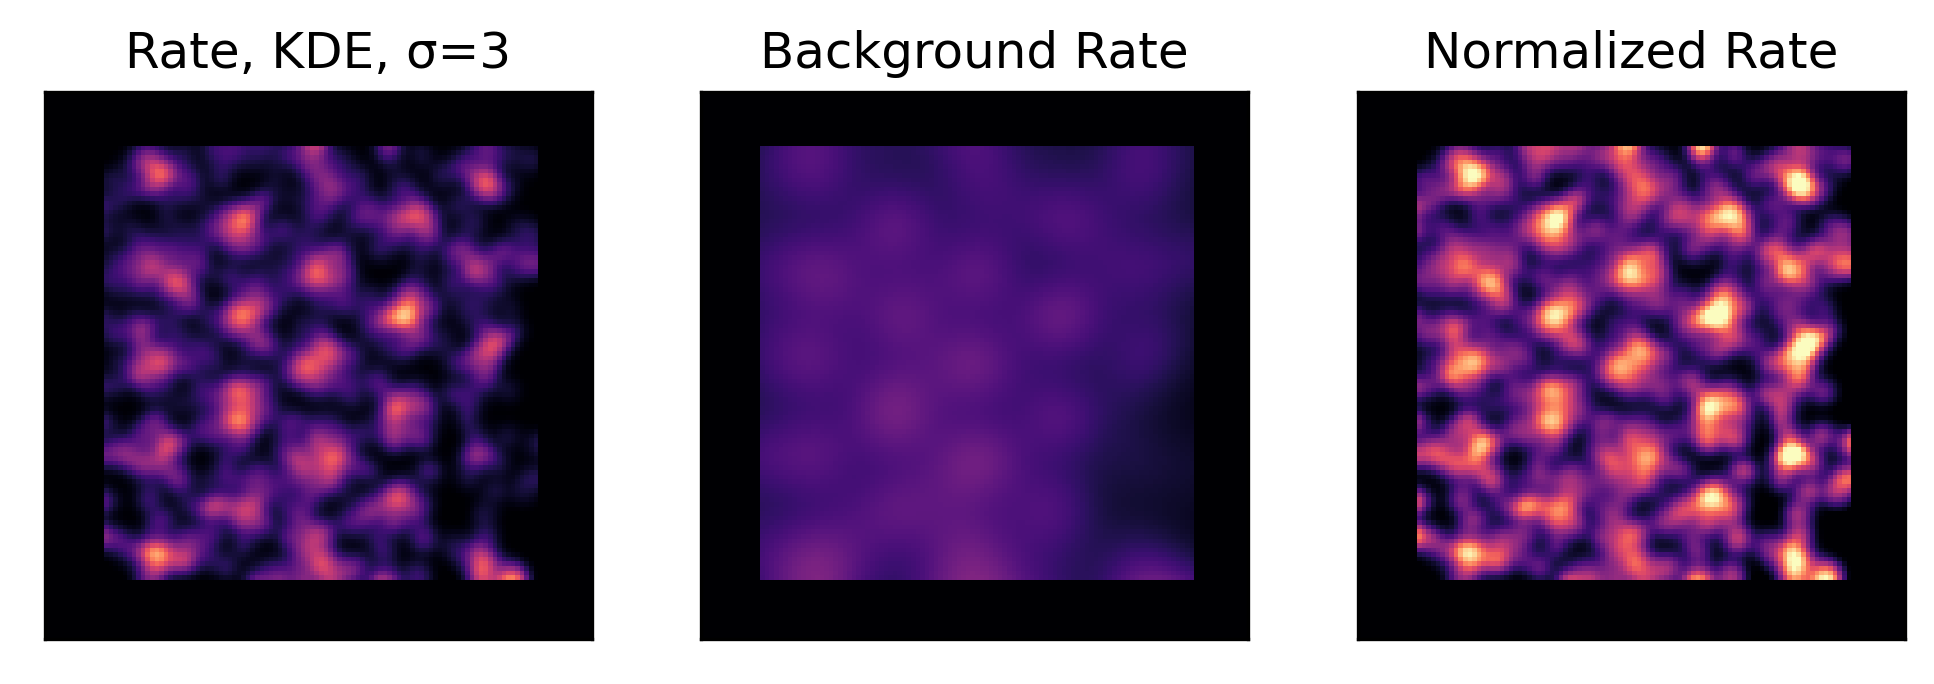

In [4]:
def blurkernel(L,σ,normalize=False):
    # Gaussian kernel
    k = exp(-(arange(-L//2,L//2)/σ)**2)
    if normalize: 
        k /= sum(k)
    return fftshift(k)

def conv(x,K):
    # Compute circular 2D convolution using FFT
    # Kernel K should already be fourier-transformed
    return real(ifft2(fft2(x)*K))

def blur(x,σ,**kwargs):
    # 2D Gaussian blur via fft
    kern = fft(blurkernel(x.shape[0],σ,**kwargs))
    return conv(x,outer(kern,kern))

def kdeλ(N,K,σ,**kwargs):
    # Estimate rate using Gaussian KDE
    return regλ(blur(N,σ),blur(K,σ),**kwargs)

blurσ = 3 # Kernel radius
bgσ   = 9 # Background kernel radius

# KDE estimate of rate
λhat  = kdeλ(N,K,blurσ) 
printstats(λ0,λhat,'KDE Error')

# local background rate
λbg  = kdeλ(N,K,bgσ)
# background-normalized rate
λbar = λhat/λbg

v2 = 2.5 # Color limits for normalized rate
subplot(131); imshow(λhat*mask,vmin=0,vmax=v1)
notic(); title('Rate, KDE, σ=%d'%blurσ);
subplot(132); imshow(λbg*mask,vmin=0,vmax=v1)
notic(); title('Background Rate');
subplot(133); imshow(λbar*mask,vmin=0,vmax=v2)
notic(); title('Normalized Rate');

## Inspecting the data

Kernel density smoothing yields a good estimate of the rate map, but we first need to know how much to blur the spike count data. Here, we set the blur radius $\sigma$ manually, but we can also pick $\sigma$ in a principled way by examining the autocorrelation of the data. We can calculate the 2D autocorrelation [efficiently using the FFT](https://en.wikipedia.org/wiki/Autocorrelation#Efficient_computation). To focus on fluctuations around the mean rate, we should first subtract any constant component.

For grid cells, the 2D autocorrelation should show a hexagon (below, left), which reflects the three sinusoidal components that make up the periodic grid tiling. Sometimes, cells don't have a perfectly hexagonal grid, or might have slightly different spacing in different directions. However, in this case we focus on cells that have an approximately uniform grid. 

We can collapse this 2D autocorrelation down to 1D by averaging this 2D autocorrelation as a function of radial distance. This radial autocorrelation has a large peak at zero lag, but also several smaller peaks due to the periodicity of the firing function. We can estimate the grid spacing based on the location of the first non-zero-lag peak (below, right)

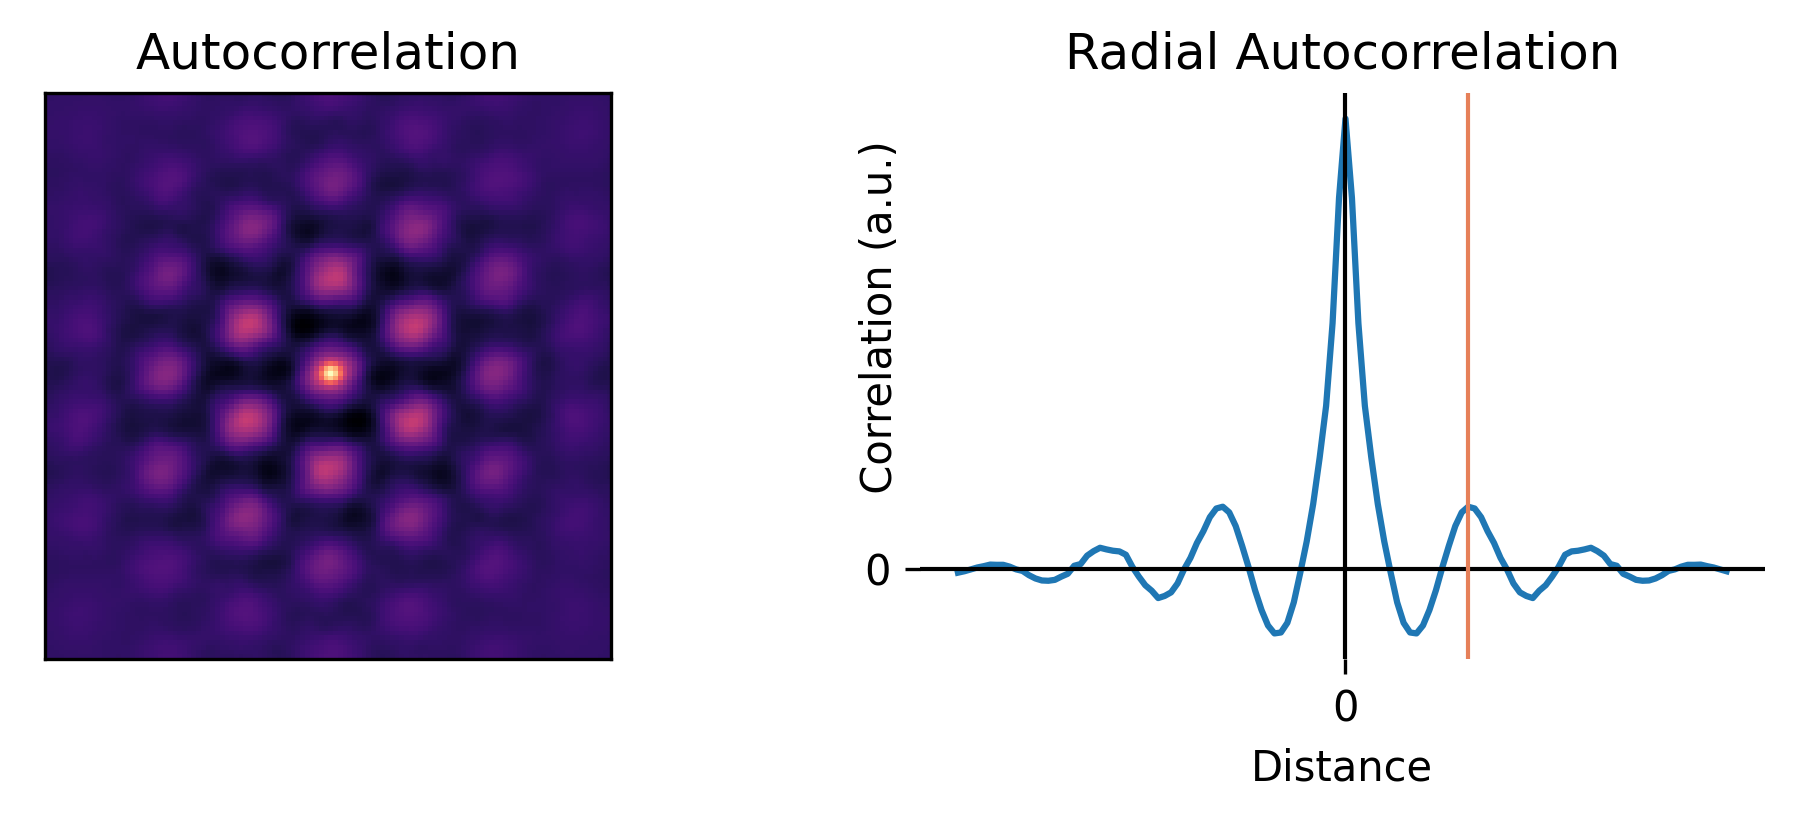

In [5]:
def zeromean(x):
    # Mean-center data, accounting for masked-out bins
    return (x-mean(x[mask]))*mask

def fft_acorr(x):
    # Zero-lag normalized to match signal variance
    x   = zeromean(x)
    # Window attenuates boundary artefacts
    win = hanning(L)
    win = outer(win,win)
    # Calculate autocorrelation using FFT
    psd = (abs(fft2(x*win))/L)**2
    acr = fftshift(real(ifft2(psd)))
    # Adjust peak for effects of mask, window
    return acr*var(x[mask])/acr[L//2,L//2]

def radial_average(y):
    # Get radial autocorrelation by averaging 2D autocorrelogram
    i = int32(abs(coords)) # Radial distance
    a = array([mean(y[i==j]) for j in range(L//2+1)])
    return concatenate([a[::-1],a[1:-1]])

def radial_acorr(y):
    return radial_average(fft_acorr(y))

# Use small, conservative blur for initial rate esitmate
λhat = kdeλ(N,K,1.5)
# Subtract the mean and get 2D autocorrelation
acorr2 = fft_acorr(λhat)
# Average to get radial autocorrelation
acorrR = radial_average(acorr2)
# Get distance to first peak in bins
from scipy.signal import find_peaks
P = np.min(find_peaks(acorrR[L//2+2:])[0])+1

subplot(121); imshow(acorr2)
notic(); title('Autocorrelation');
subplot(122); plot(acorrR)
[gca().spines[s].set_visible(0) for s in ['top','right','bottom','left']]
xticks([L//2],'0'), yticks([0]);
title('Radial Autocorrelation');
xlabel('Distance'); 
ylabel(' '*9+'Correlation (a.u.)',labelpad=-9)
axhline(0,color='k',lw=1); 
axvline(L//2,color='k',lw=1)
axvline(L//2+1+P,color=[.9,.5,.35],lw=1);

Once we have grid spacing $P$, we can define other relevant scales. We want to smooth as much as possible, but not so much that we erase the underlying grid. A Gaussian with $\sigma = \frac{2P}{2\pi}$ is a good heuristic for the largest acceptable smoothing radius. For subtracting the background, we the smallest radius that still filters out the grid. For this, $\sigma_{bg} = \frac{4P}{2\pi}$ is a good heuristic.

KDE:
> Normalized MSE: 23.5%
> Pearson correlation: 0.75


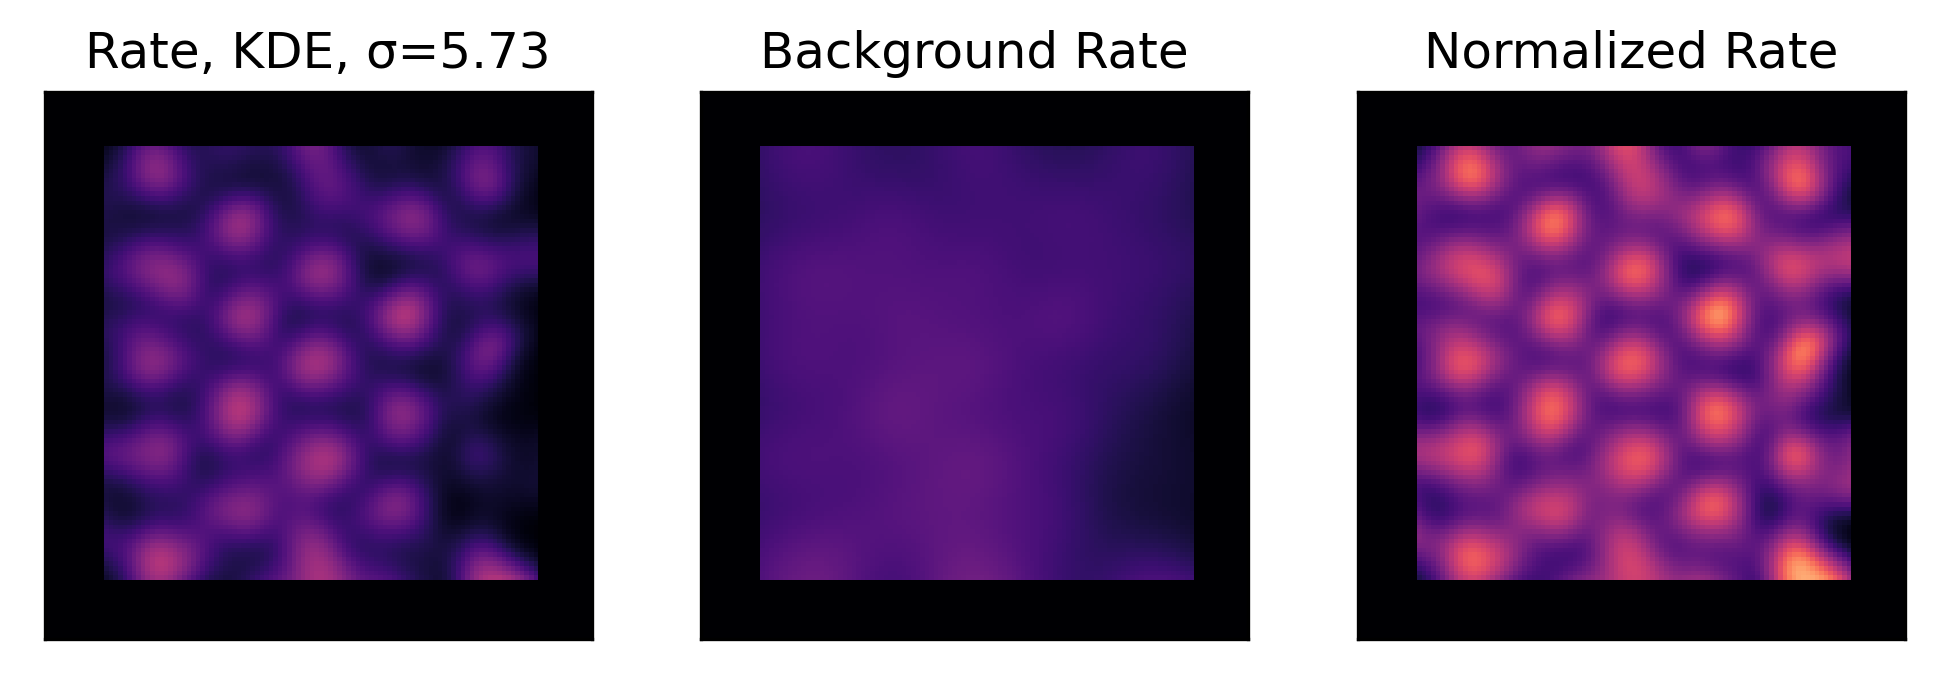

In [6]:
blurσ = P/pi
bgσ   = blurσ*2
λhat  = kdeλ(N,K,blurσ) 
λbg   = kdeλ(N,K,bgσ)
λbar  = λhat/λbg

# How good are the KDE and normalized KDR estimators?
printstats(λ0,λhat,'KDE')

subplot(131); imshow(λhat*mask,vmin=0,vmax=v1)
notic(); title('Rate, KDE, σ=%0.2f'%blurσ);
subplot(132); imshow(λbg*mask,vmin=0,vmax=v1)
notic(); title('Background Rate');
subplot(133); imshow(λbar*mask,vmin=0,vmax=v2)
notic(); title('Normalized Rate');

## Smoothing with Gaussian Process regression

KDE smoothing is ok, but we can do better. Gaussian Process (GP) regression provides a flexible way to handle missing data, and also lets us encode more assumptions about the spatial correlations in the underlying rate map. 

Let's start by implementing smoothing using GP regression. Recall the formula for the GP posterior: 

$$
\begin{aligned}
\Sigma 
&= \left[\Sigma_0^{-1} + \Sigma_\epsilon^{-1}  \right]^{-1}
\\
\mu
&= \Sigma \left[\Sigma_0^{-1}\mu_0 + \Sigma_\epsilon^{-1}y \right] 
\end{aligned}
$$

If we set the prior means to zero, the posterior mean simplifies to: 

$$
\begin{aligned}
\hat\lambda = \Sigma \Sigma_1^{-1} y = \left[\Sigma_0^{-1} + \Sigma_\epsilon^{-1}  \right]^{-1} \Sigma_\epsilon^{-1}y
\end{aligned}
$$

Let's initially assume that each time the rat visits a location, the spike count reflects the true underlying rate with some uncertainty $\sigma_\epsilon^2$. (We'll explore better noise models later.)

Most treatments of GP regression treat each observation separately. If we were analyzing actual grid-cell recordings, this would mean that $y$ and $\sigma_\epsilon$ have as many entries as we have timepoints in our data. This problem is too large to solve efficiently, but binning data to the grid offers a faster solution. 

When we bin observations to the grid, we effectively lump $N$ observations together into a single estimate. Points with more visits therefore have less error. We can therefore treat our binned observations are new observations, but with an error model adjusted to reflect this decreased error. In particular, if the error for a single measurement is $\sigma_\epsilon^2$, then the error for $N$ measurements is $\sigma_\epsilon^2/N$. 

Bins without data ($N=0$) might seem to pose an issue at first, since their measurement values and error is undefined. This is not an issue in practice if we work with *precision* rather than variance. Precision $\tau$ of a Gaussian variable is defined as the reciprocal of its variance, $\tau=1/\sigma^2$ (or, for multivariate Gaussians: the inverse of the covariance matrix). For $N$ measurements, then, we have $\tau = N/\sigma_\epsilon^2$, which is well-defined when $N=0$. We therefore define the precision matrix of the observations as 

$$
\Sigma^{-1}_\epsilon = \operatorname{diag}[\sigma_\epsilon^2/\operatorname{vec}[N]],
$$

where $\operatorname{diag}[]$ denotes constructing a diagonal matrix from a vector, and $\operatorname{vec}[N]$ denotes unravelling the $L{\times}L$ array into a length $L^2$ vector. This matrix $\Sigma^{-1}_\epsilon$ will be singular, but this is no issue since it will be added to the prior precision, which should be full-rank.

We must also construct the prior covariance matrix $\Sigma_0$. This amounts to evaluating our smoothing kernel $\kappa(\mathbf x,\mathbf x')$ for all pairs of bins. Ordinarily, we should also optimize the kernel $\kappa(\mathbf x,\mathbf x')$. This is done by adjusting the kernel parameters to maximize the probability of the observations given the GP prior. For this demo, we configure the kernel heuristically: we pick a fixed, arbitrary smoothing radius. Ideally, the zero-lag value of the kernel should match the variance of the underlying function being inferred (the kernel is, essentially, a prior assumption about the autocorrelation of the function being inferred). For expediency, we simply set the kernel height to the sample variance here.

For larger problems, the prior covariance might not fit in memory. [An alternative solution](https://math.stackexchange.com/questions/3952494/efficient-product-of-vector-with-inverse-of-positive-definite-circulant-matrix-p?noredirect=1#comment8150195_3952494) is possible by solving the linear system via gradient descent and leveraging the FFT. In practice even this can be tricky. I found that most of Scipy's solvers performed poorly, with the exception of conjugate gradient. Even conjugate gradient failed to converge to high precision, and in practice naive gradient descent converged to a more accurate solution, albeit slowly. It is also necessary to ensure that $\Sigma_0$ does not contain any small eigenvalues that could make the linear problem ill-conditioned.

GP:
> Normalized MSE: 11.8%
> Pearson correlation: 0.84


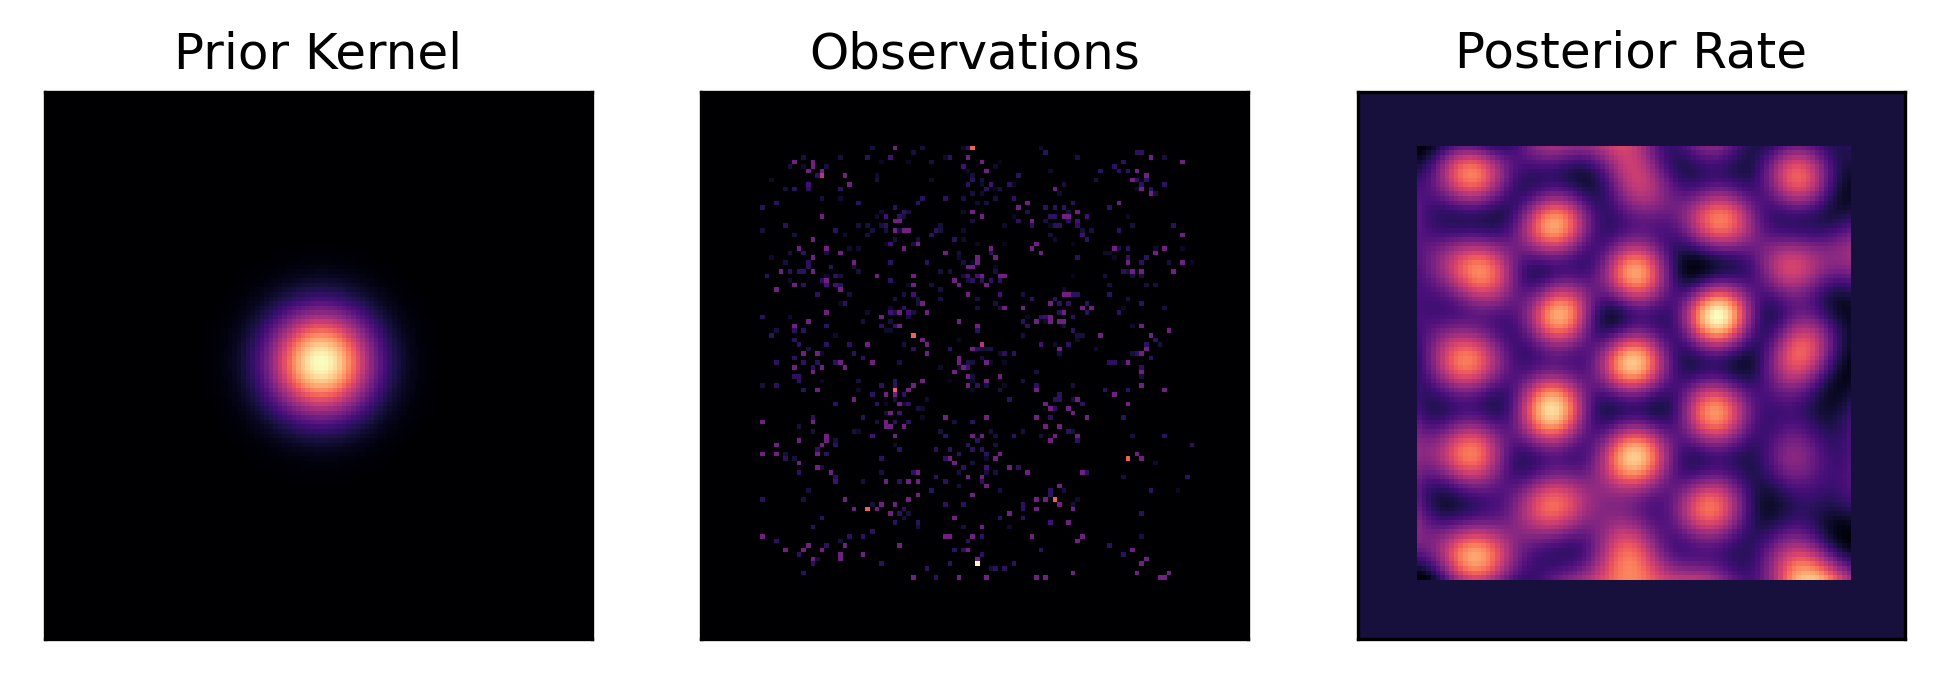

In [7]:
from scipy.linalg import cholesky as chol
from scipy.linalg.lapack import dtrtri
from scipy.linalg import circulant 

def cinv(x):
    # Invert PSD quickly via Cholesky
    ich = dtrtri(chol(x))[0]
    return ich.dot(ich.T)

def repair_small_eigenvalues(kern,mineig=1e-6):
    # Kernel must be positive; fix small eigenvalues
    assert(argmax(kern.ravel())==0)
    kfft = fft2(kern)
    keig = abs(kfft)
    υmin = mineig*np.max(keig)
    zero = keig<υmin
    kfft[zero] *= υmin/abs(kfft[zero])
    kern = real(ifft2(maximum(υmin,kfft)))
    return kern

def kernel_to_covariance(kern):
    # Covariance is a doubly block-circulant matrix
    # Use np.circulant to build blocks, then copy
    # with shift to make 2D block-circulant matrix
    assert(argmax(kern.ravel())==0)
    L = kern.shape[0]
    b = array([circulant(r) for r in kern])
    b = b.reshape(L**2,L).T
    s = array([roll(b,i*L,1) for i in range(L)])
    return s.reshape(L**2,L**2)

def trim(x):
    # Remove masked regions (faster)
    i = mask.ravel()
    return x[i,:][:,i] if len(x.shape)==2 else x[i]

def untrim(x):
    # Put back masked regions in trimmed object
    i = mask.ravel()
    u = eye(L*L)[i]
    if len(x.shape)==2:
        return (u.T@x@u).reshape(L**2,L**2)
    else:
        return (u.T@x).reshape(L,L)

def solveGP(kern,y,τe):
    kern = repair_small_eigenvalues(kern)
    Σ0 = trim(kernel_to_covariance(kern))
    τe = trim(τe)
    Lm = sum(mask)
    μy = mean(y[mask])
    ye = trim(zeromean(y).ravel())
    return untrim(solve(Σ0*τe+eye(Lm),Σ0@(τe*ye))) + μy

# Prepare error model for GP
ε0 = mean(K)/mean(N) # variance per measurement
τe = N.ravel()/ε0    # precision per bin

# Build 2D kernel for the prior
# Scale kernel height to match data variance (heuristic)
k1   = blurkernel(L,blurσ*2)
y    = nan_to_num(K/N)
kern = outer(k1,k1)*var(y[mask])

# Solve for posterior mean
λGP1 = solveGP(kern,y,τe)

# How good is the GP estimator?
printstats(λ0,λGP1,'GP')

subplot(131); imshow(fftshift(kern)); notic(); title('Prior Kernel');
subplot(132); imshow(y*mask);         notic(); title('Observations');
subplot(133); imshow(λGP1*mask);      notic(); title('Posterior Rate');

# Sometimes, GP regression reduces to convolution

It seems like GP regression yields similar results to kernel density estimation. Can we relate these two operations? Recall the solution for the GP posterior:

$$
\begin{aligned}
\mu = \left[\Sigma_0\Sigma_\epsilon^{-1}+I\right]^{-1}\Sigma_0\Sigma_\epsilon^{-1}y.
\end{aligned}
$$

Now, the prior $\Sigma_0$ is a positive semi-definite matrix, so it can be written in terms of the eigenvalue decomposition

$$
\Sigma_0 = \text F \operatorname{diag}[\tilde k] \text F^{-1},
$$

where $\tilde k$ is a vector of eigenvalues and $F$ is a unitary basis. If $\Sigma_\epsilon^{-1}$ can also be diagonalized by $F$ as $\Sigma_\epsilon^{-1} = F \operatorname{diag}[\tilde\tau] F^\top$, then the solution for the GP posterior simplifies to 

$$
\begin{aligned}
\mu = \text F \operatorname{diag}\left[\frac {\tilde k \tilde \tau} {\tilde k \tilde \tau + 1}\right] \text F^{-1} y
\end{aligned}
$$

Generally, $\Sigma_\epsilon^{-1}$ won't share an eigenspace with $\Sigma_0$. But, in the special case that all measurements have noise $\sigma_\epsilon^2$, the precision matrix $\Sigma_\epsilon^{-1} = I/\sigma_\epsilon^2$ is proportional to the identity. The GP posterior then reduces to:

$$
\begin{aligned}
\mu = \text F \operatorname{diag}\left[\frac {\tilde k} {\tilde k + \sigma_\epsilon^2}\right] \text F^{-1} y
\end{aligned}
$$

When the Gaussian process is evaluated on a regularly-spaced grid as we have done here, the eigenspace $\text F$ is Fourier space, and is the operator $\text F$ that performs the (unitary) Fourier transform. The above matrix operations can therefore be computed as a convolution using the FFT, vastly accelerating performance. This implies that the GP regression on a regular grid, with homogeneous measurement noise, is equivalent to KDE smoothing with the kernel $g(\mathbf x,\mathbf x')$, and can be computed with the following convolution ($\otimes$):

$$
\begin{aligned}
g(\mathbf x,\mathbf x') &= \text F^{-1} \operatorname{diag}\left[\frac {\tilde k} {{\tilde k} + \sigma_\epsilon^2}\right]
\\
\mu&\approx g \otimes y.
\end{aligned}
$$

When the measurement error is large $\sigma_\epsilon^2\gg\tilde k$, $g(\mathbf x,\mathbf x')$ reduces to a convolution kernel approximately proportional to our prior covariance kernel $k$. When the measurement error is small $\sigma_\epsilon^2\ll\tilde k$, convolution with $g(\mathbf x,\mathbf x')$ approximates the identity transformation, i.e. $g(\mathbf x,\mathbf x')$ approximates a delta distribution. 

In practice this connection between convolution and GP estimation is not especially useful: cases where a GP is evaluated on a regular grid with homogeneous measurement noise are rare. But, this highlights that sometimes simply filtering the data in space with a convolution kernel gives you something almost as good as a GP regression, at a fraction of the computational cost. In many cases this is good enough.

Error of convolution approximation:
> Normalized MSE: 24.0%
> Pearson correlation: 0.86
How close are GP regresion and convolution?:
> Normalized MSE: 15.0%
> Pearson correlation: 0.93


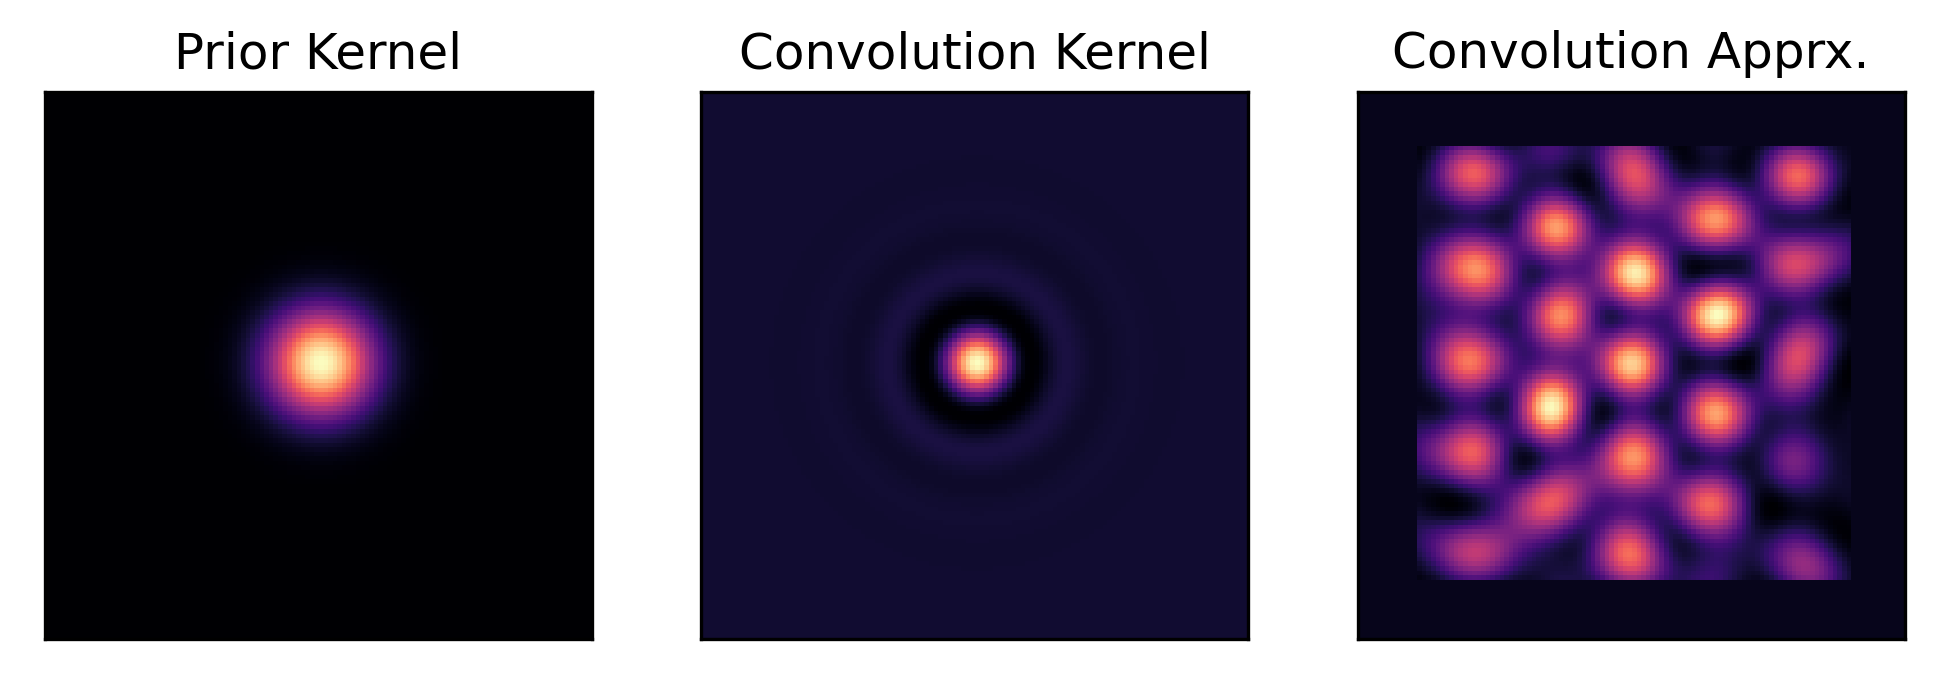

In [8]:
# Treat measurement noise as homogenous
# then GP inference is KDE convolution
kft1 = fft2(kern)
μτ   = mean((N/ε0)[mask])
kftc = (kft1*μτ)/(kft1*μτ+1)
kcon = real(ifft2(kftc))
μy   = mean(y[mask])
λcnv = conv(y-μy,kftc)+μy

printstats(λcnv,λ0  ,'Error of convolution approximation')
printstats(λcnv,λGP1,'How close are GP regresion and convolution?')

subplot(131); imshow(fftshift(kern)); notic(); title('Prior Kernel');
subplot(132); imshow(fftshift(kcon)); notic(); title('Convolution Kernel');
subplot(133); imshow(λcnv*mask);      notic(); title('Convolution Apprx.');

# Better priors

So far, we've only used GP regression with a Gaussian prior. When analyzing data from grid cells, the real power of GP regression lies in being able to encode the knowledge that the grid should be periodic into the GP prior kernel. In this section, we'll construct a periodic prior.

To construct a periodic prior, we estimate the idealize (theoretical) autocorrelation from a perfect grid (below, left). To avoid assuming any particular orientation, we make the kernel radially symmetric (below, middle). To avoid inferring long-range interactions where none exist, we taper the kernel to look only at the local neighborhood (below, right). Finally, we adapt the kernel to the observed statistics of the spike count data by scaling the zero-lag peak in the kernel to match a estimate of the variance in the rate. The zero-lag autocorrelation of the data reflects the sum of the true variance in the underlying rates, plus the average measurement noise. To remove the contribution from the measurement noise, we estimating the zero-lag variance by fitting a quadratic polynomial to the correlation at nearby, nonzero lags.

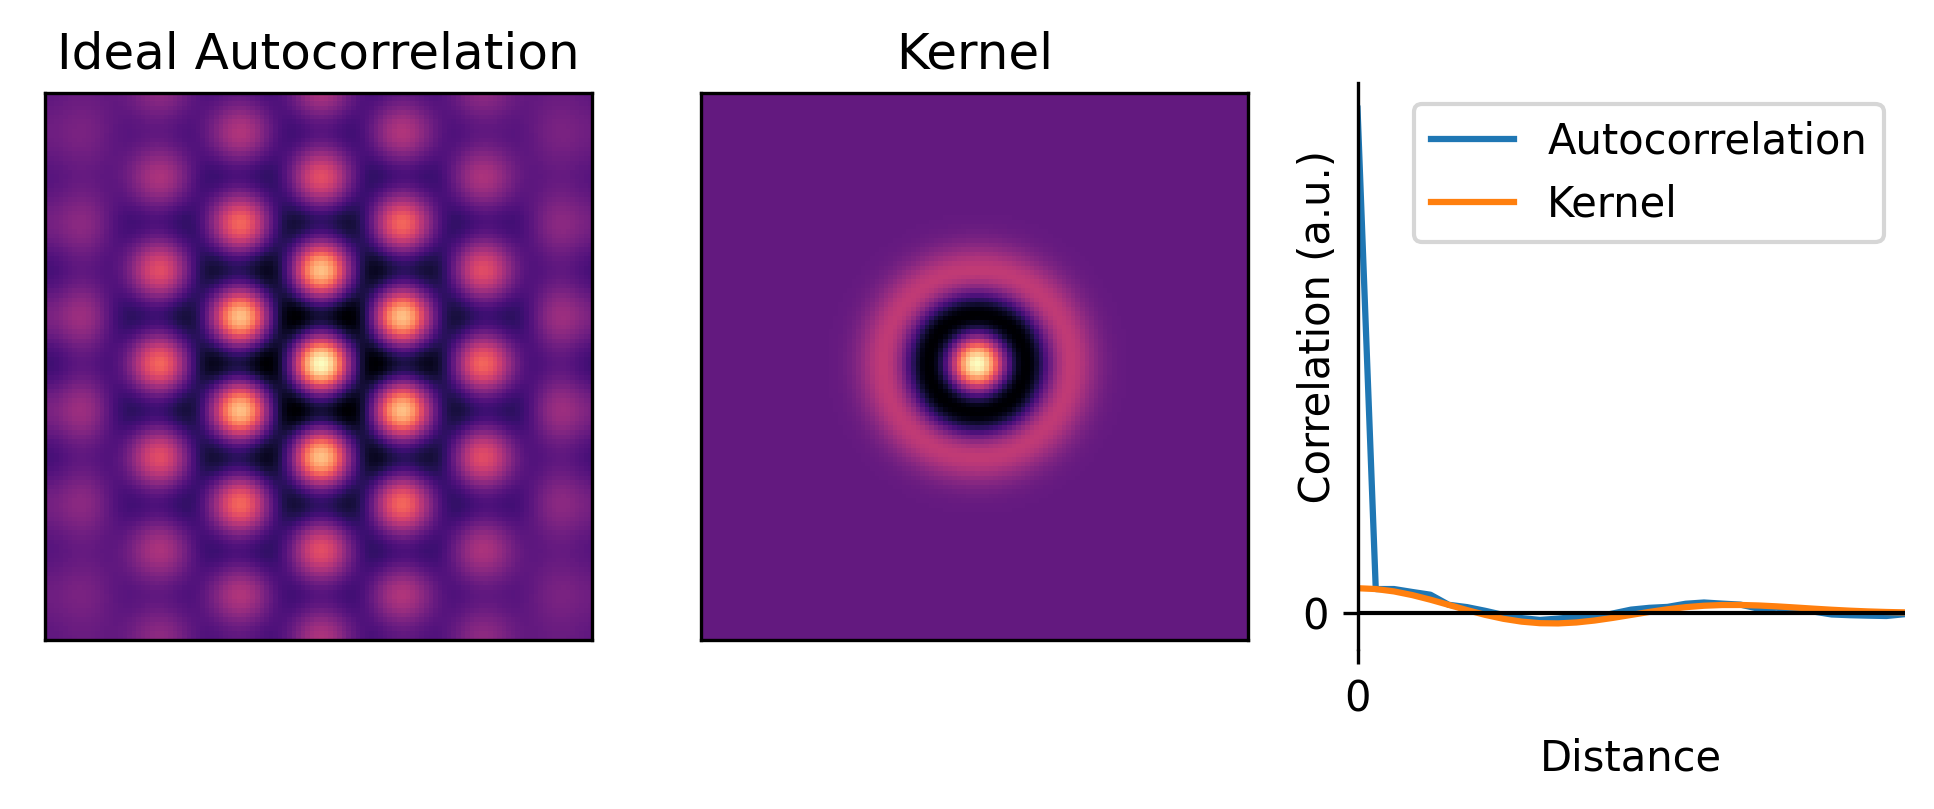

In [21]:
def zerolag(ac,r=3):
    # Estimate true zero-lag variance via polynomial interpolation.
    z = array(ac[L//2-r:L//2+r+1])
    v = arange(r*2+1)
    return polyfit(v[v!=r],z[v!=r],2)@[r**2,r,1]

from scipy.interpolate import interp1d
def radial_kernel(rk):
    # Make radially symmetric 2D kernel from 1D radial kernel
    r    = abs(coords)
    kern = interp1d(arange(L//2),rk[L//2:],fill_value=0,bounds_error=0)(r)
    return fftshift(kern)

# Make symmetric kernel from autocorrelation of ideal grid
grid  = ideal_hex_grid(L,P)
acgrd = fft_acorr(grid)
axR   = radial_average(acgrd)
kernR = radial_kernel(axR)

# Restrict kernel to local neighborhood
negative = where(axR[L//2:]<0)[0]
nextpeak = np.min(negative[negative>P])
window   = abs(coords)<nextpeak
kern0    = kernR*fftshift(window)

# Smooth kernel to remove high frequencies we don't need
# and normalize to unit height
σmin  = P/pi
kern0 = blur(kern0,σmin)
kern0 = kern0/np.max(kern0)

# Estimate true zero-lag variance and scale kernel
acorrR1 = radial_acorr(regλ(N,K))
acorrR2 = copy(acorrR1)
v0      = zerolag(acorrR1)
kern    = kern0*v0
acorrR2[L//2] = v0
    
subplot(131); imshow(acgrd);          notic(); title('Ideal Autocorrelation');
subplot(132); imshow(fftshift(kern)); notic(); title('Kernel');
subplot(133)
plot(acorrR1[L//2:]  ,label='Autocorrelation')
plot(kern[0,:L//2],label='Kernel')
xticks([0]) 
yticks([0])
legend()
axhline(0,color='k',lw=1)
xlabel('Distance')
ylabel(' '*6+'Correlation (a.u.)',labelpad=-9)
xlim(0,L//4)
[gca().spines[s].set_visible(0) for s in ['top','right','bottom']];

GP with periodic kernel:
> Normalized MSE: 16.9%
> Pearson correlation: 0.90


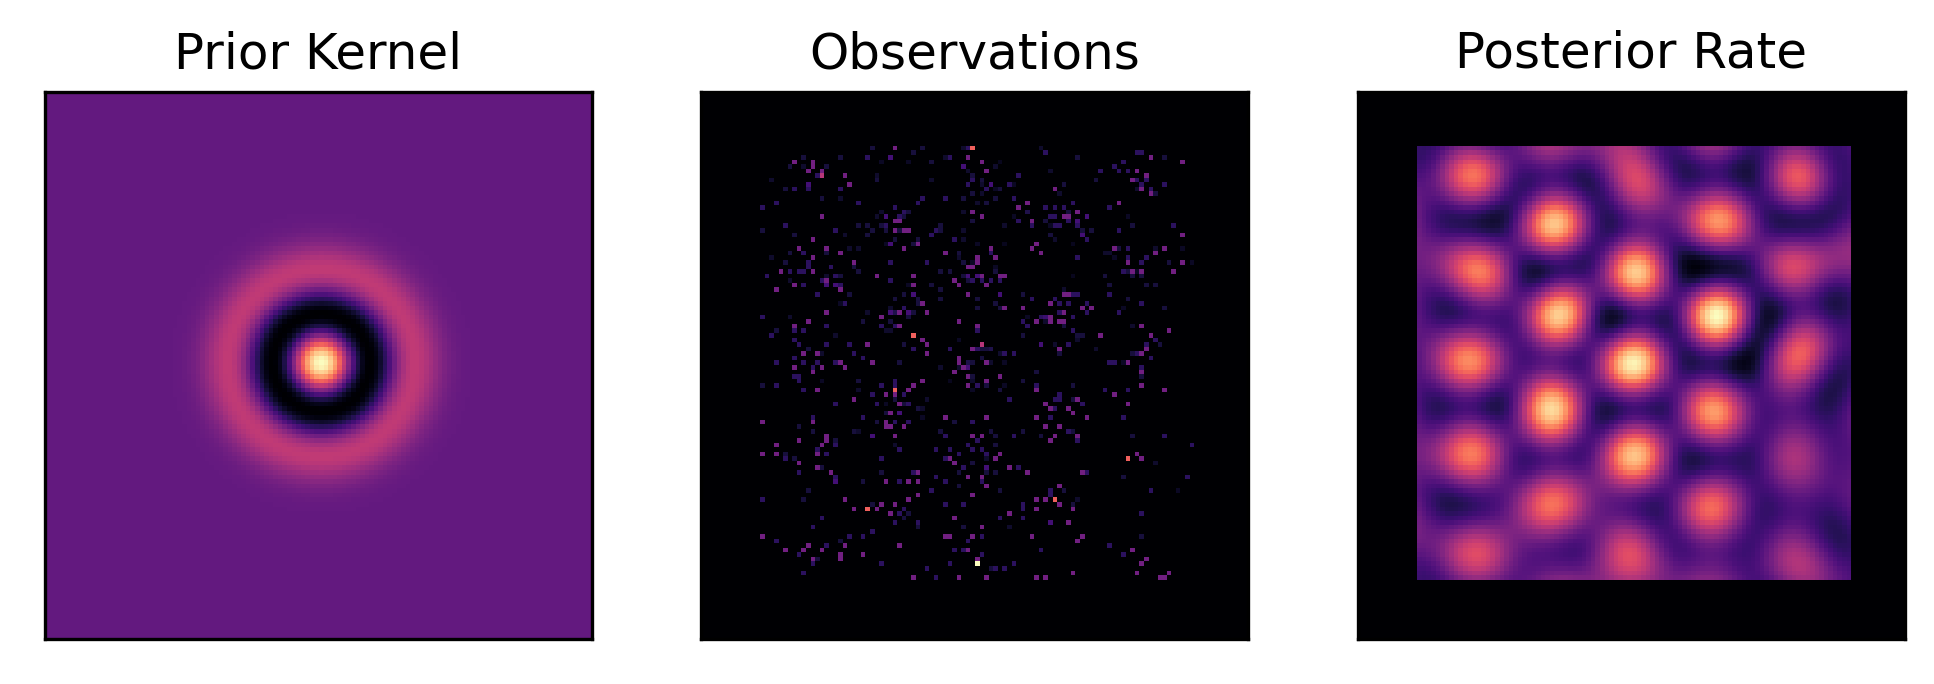

In [10]:
# Solve for posterior
ε0   = mean(regλ(N,K,1,.5)[mask])
τe   = N.ravel()/ε0
λGP2 = solveGP(kern,y,τe)

# How good is the GP estimator?
printstats(λ0,λGP2,'GP with periodic kernel')

subplot(131); imshow(fftshift(kern)); notic(); title('Prior Kernel');
subplot(132); imshow(y*mask);         notic(); title('Observations');
subplot(133); imshow(λGP2*mask);      notic(); title('Posterior Rate');

# Heuristic approximation of Poisson noise

So far, we've only considered an arbitrary, fixed measurement error. But, neuronal spiking is typically treated as conditionally Poisson, which means its variance should be proportional to the firing rate. Eventually, we will construct a Gaussian process model that properly incorporates this Poisson noise assumption. First, let's explore a heuristic way to incorporate a Poisson noise assumption into our GP regressions. Earlier, we discussed how the gamma distribution could serve a conjugate prior for Poisson count data. We can also use a Gamma distribution to model the measurement uncertainty from a collection of Poisson observations, and incorporate this model of uncertainty into our GP regression.

The variance of a $\operatorname{Gamma}(\alpha,\beta)$ distribution is $\sigma^2=\alpha/\beta^2$. As discussed earlier, our regularized rate estimator given $K$ spikes in $N$ visits to a given location yields a Gamma distribution with with $\alpha = K+\rho(\mu-1)+1$ and $\beta=N+\rho$. The variance of this distribution, then, is

$$
\sigma^2_\epsilon=\frac{\alpha}{\beta^2}=\frac{K+\rho(\mu-1)+1}{(N+\rho)^2} = \frac{\hat\lambda}{N+\rho}.
$$

For GP regression, we want to incorporate most of our prior assumptions into the GP prior kernel. This means that we should us only a small amount of regularization $\rho$ when calculating the observations and their uncertainty in each bin. For $\rho=0$ this reduces to 

$$
\sigma^2_\epsilon=\frac{\alpha}{\beta^2}=\frac{K+1}{N^2}.
$$

Performance for this model of the error is mixed: it can work better than assuming constant error when data are limited, but sometimes performs worse than simply assuming uniform variance equal to the neuron's average firing rate. We discuss a more principled way to handle Poisson noise in the next section. 

GP:
> Normalized MSE: 424.7%
> Pearson correlation: 0.49


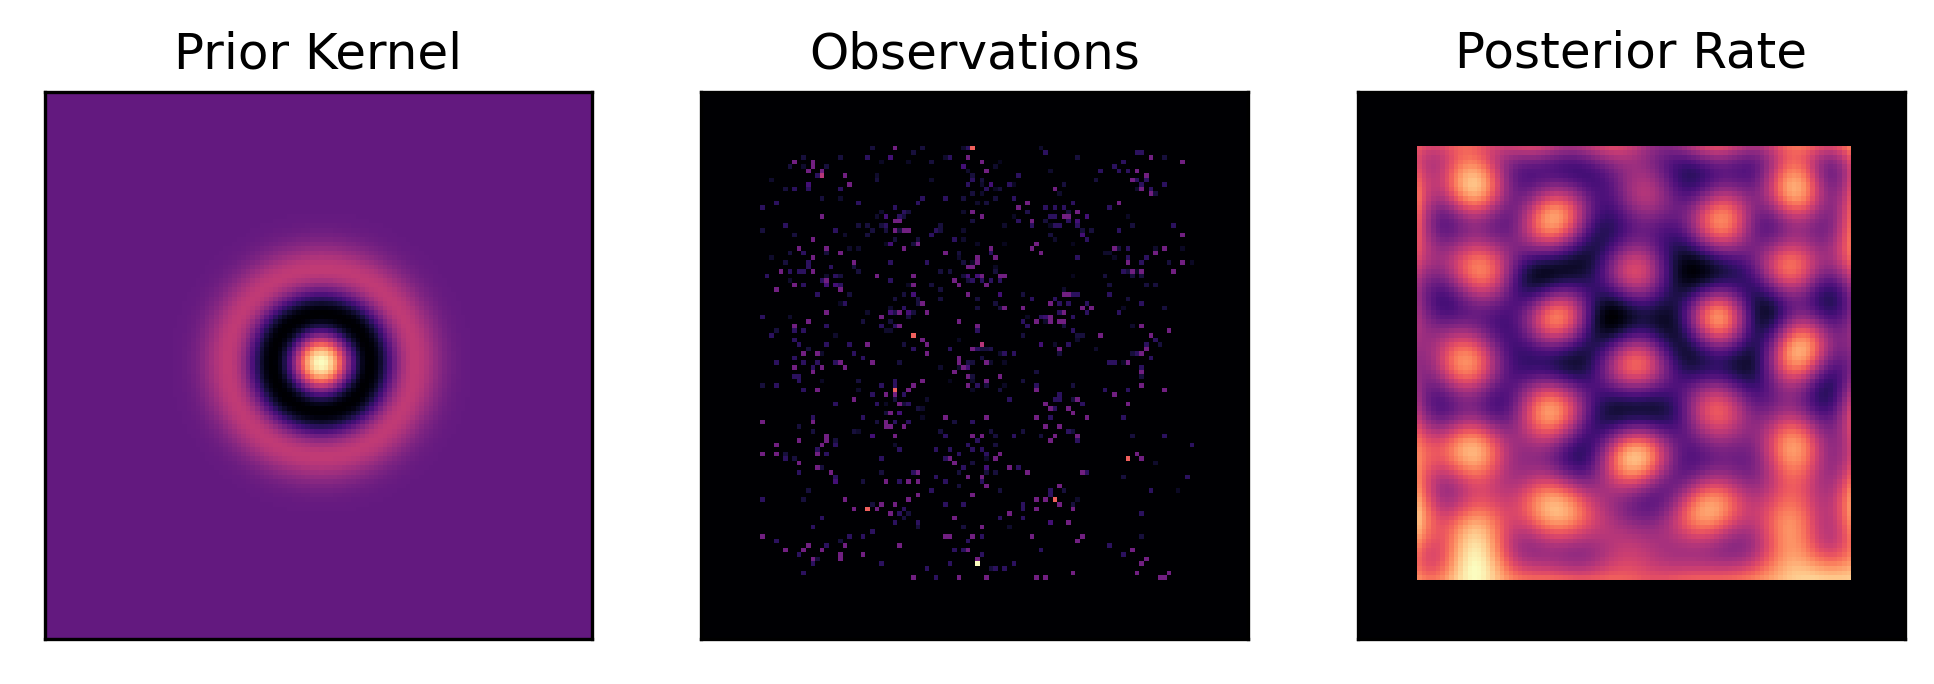

In [11]:
# Use estimated rate as measurement error variance
τe   = (N/regλ(N,K,1,.5)).ravel()
λGP3 = solveGP(kern,nan_to_num(K/N),τe)

# How good is the GP estimator?
printstats(λ0,λGP3,'GP')

subplot(131); imshow(fftshift(kern)); notic(); title('Prior Kernel');
subplot(132); imshow(y*mask);         notic(); title('Observations');
subplot(133); imshow(λGP3*mask);      notic(); title('Posterior Rate');

## Working in normalized rate

We can infer normalized rates directly with GP regression by dividing our observations by the background rate. This also scales the observation error by the background rate, squared. If we use the mean firing rate $\mu_\lambda={\langle K\rangle}/{\langle N\rangle}$ to set the per-sample error variance, then the measurements $y$ and their errors $\sigma^2_\epsilon$ are: 

$$
\begin{aligned}
\\
y &= \frac{K}{N \bar\lambda}
\\
\sigma^2_\epsilon &= \frac {\mu_\lambda}{N \bar\lambda^2},
\end{aligned}
$$

where $\bar\lambda$ is our estimated background rate.

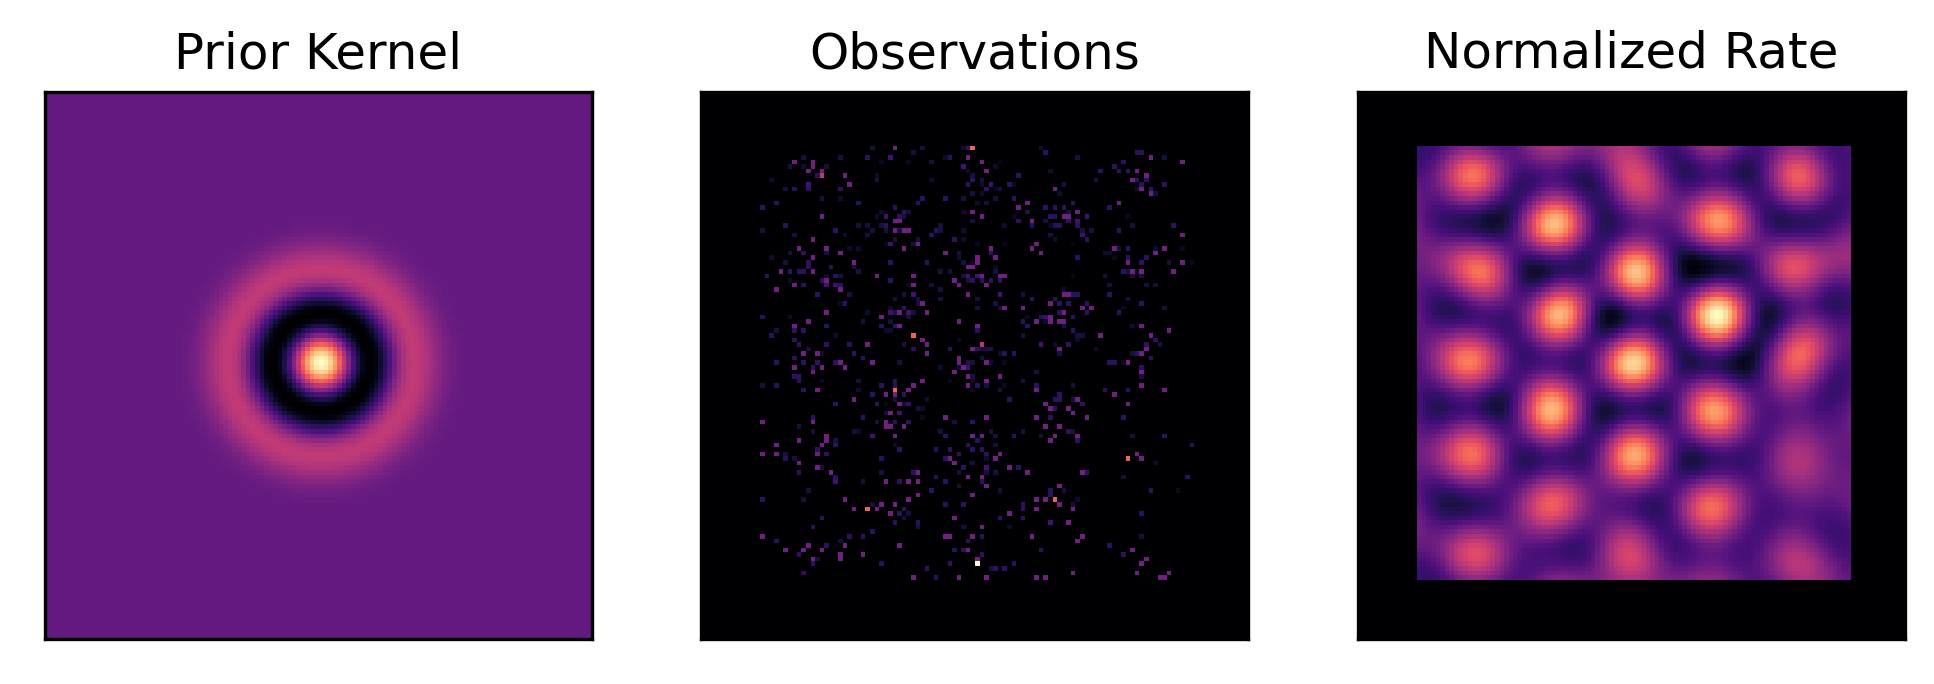

In [12]:
# Calibrate prior for normalized rate
λhat = regλ(N,K)
λbg  = kdeλ(N,K,bgσ)
kern = kern0*zerolag(radial_acorr(λhat/λbg))

# Solve for posterior
τe   = (N*λbg**2/ε0).ravel()
λGP4 = solveGP(kern,nan_to_num(K/N)/λbg,τe)

subplot(131); imshow(fftshift(kern)); notic(); title('Prior Kernel');
subplot(132); imshow(y*mask);         notic(); title('Observations');
subplot(133); imshow(λGP4*mask);      notic(); title('Normalized Rate');

# Log-Gaussian Cox Processes

So far, we've been using GP regression to estimate the underlying rate. This works, but entails some heuristic decisions about how to model measurement noise. Can we do better? 

We can get an even better model of the data by fitting a log-Gaussian [Cox process](https://en.wikipedia.org/wiki/Point_process#Cox_point_process) model to the binned count observations. This places a Gaussian process prior on the logarithm of the intensity, $\ln(\lambda)$, and assumed that spike count observations are conditionally Poisson: 

$$
\begin{aligned}
y&\sim\operatorname{Poisson}(\lambda)
\\
\lambda &= \exp(\mathbf w^\top \mathbf x + \beta)
\\
\mathbf w&\sim \mathcal N(0,\Sigma_0)
\end{aligned}
$$

Above, $\mathbf w$ are the log-rates that we want to infer, and $\mathbf x$ is a an indicator vector which is 1 for the rat's current binned location and zero otherwise. The parameter $\beta$ is a constant bias term. 

Recall that the probability of observing spike count $y$ given rate $\lambda$, for Poisson-distributed spike counts, is:

$$
\Pr(y|\lambda) = \frac {\lambda^y e^{-\lambda}} {\Gamma(y+1)}
$$

We work with log-probability for numerical stability. The log-probability of observing spike count $y$ given rate $\lambda$, for Poisson-distributed spike counts, is:

$$
\ln\Pr(y|\lambda) = y \ln \lambda -\lambda + \text{const.}
$$

We estimate a posterior distribution on $\mathbf w$ by multiplying our Gaussian process prior by this Poisson likelihood, for all $T$ time points. 

## The Maximum a posteriori estimate

We find $\mathbf w$ that maximizes the posterior probability of the observed spike counts. This is the [Maximum A Posteriori](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) (MAP) estimator. For this, we need only calculate the posterior log-probability up to a constant. By convention, we work with the negative log-posterior so that finding the MAP is a minimization problem. 

The negative log-posterior $\mathcal L=-\ln\Pr(Y|x,\mathbf w,\beta)$, summed over all observations $Y=\{y_1,..,y_T\}$, $\mathbf X=\{\mathbf x_1,..,\mathbf x_T\}$, is:

$$
\begin{aligned}
\mathcal L &= 
\tfrac 1 2 \mathbf w^\top \Sigma_0^{-1} \mathbf w 
- \textstyle\sum_{t=1}^T [y_t \ln(\lambda_t) - \lambda_t] 
+ \text{const.}
\\
\lambda_t &= \exp(\mathbf w^\top \mathbf x_t + \beta)
\end{aligned}
$$

We bin the data into $r\in{1..R}$ spatial regions. Each site $r$ has $n_r$ visits in which we observe $k_r$ spikes. Define $\tilde\lambda_r=k_r/n_r$ as the empirical rate in each region. We can rewrite the sum over all timepoints in the log likelihood, as a sum over all spatial regions: 

$$
\begin{aligned}
\textstyle\sum_{t=1}^T y_t \ln(\lambda_t) - \lambda_t &=
\textstyle\sum_{r=1}^R n_r [ \tilde\lambda_r \ln(\lambda_r) - \lambda_r ]
\end{aligned}
$$

The negative log-posterior can then be written as:

$$
\begin{aligned}
\mathcal L =
\tfrac 1 2 \mathbf w^\top \Sigma_0^{-1} \mathbf w
+\textstyle\sum_{r=1}^R n_r [\lambda_r  - \tilde\lambda_r \ln(\lambda_r)]
+\text{const.}
\end{aligned}
$$

Written as a sum over bins like this, we write $\lambda_r$ as $\lambda_r = e^{\mathbf w^\top \mathbf x_r + \beta} = e^{\mathbf w_r + \beta}$, and the log-posterior simplifies to:

$$
\begin{aligned}
\mathcal L =
\tfrac 1 2 \mathbf w^\top \Sigma_0^{-1} \mathbf w
+\textstyle\sum_{r=1}^R n_r [e^{\mathbf w_r + \beta}  - \tilde\lambda_r (\mathbf w_r + \beta)]
+\text{const.}
\end{aligned}
$$

We find the MAP by minimizing the above as a function of $(\mathbf w,\beta)$. This can be solved via gradient descent. 
However, I found that most of the optimization routines in Scipy's `minimize` function performed poorly, either crashing, failing to terminate. Scipy's conjugate gradient method performed the best, but achieved poor error tolerance. For larger problems, using [the FFT to calculate the log-prior](https://math.stackexchange.com/questions/3952494/efficient-product-of-vector-with-inverse-of-positive-definite-circulant-matrix-p?noredirect=1#comment8150195_3952494) offered some performance improvements. 

Overall, however, I found that implementing my own Newton-Raphson method converged the most quickly and to high accuracy. However, computing the Hessian may become prohibitive for larger problems. In this case, I found that applying Scipy's conjugate gradient solver via `scipy.optimize.minimize`, and then "finishing" the optimization with ordinary gradient descent, led to good results. 

## Finding the Maximum a posteriori using Newton-Raphson

Newton-Raphson solves a linear system on each iteration. Each iteration takes the same amount of time as solving a single GP regression problems. Indeed, one can view each stage of Newton-Raphson as its own GP regression problem. This is the idea behind the [Iteratively Reweighted Least Squares](https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares) (IRLS) approach to fitting Generalized Linear Models (GLMs). The Gaussian process model used here can be viewed as a Poisson GLM with the GP prior acting as a regularizer. [Lieven Clement](https://statomics.github.io/SGA2019/assets/poissonIRWLS-implemented.html) has a good introduction on IRLS.

If we define the concatenated parameter vector $\Theta = (\mathbf w,\beta)$, each iteration of Newton-Raphson updates the parameters as

$$
\Theta_{i+1} = \Theta_{i} - \mathbf H^{-1} \mathbf J,
$$

where $\mathbf J = \nabla\mathcal L$ and $\mathbf H = \nabla\nabla^\top\mathcal L$ are the Jacobian (gradient)  and Hessian (curvature) of our negative log-posterior at the current parameter estimate $\Theta_{i}$.

To apply Newton-Raphson we need to calculate the Hessian matrix and Jacobian vector. Let's make our lives a bit easier by considering the log-prior and log-likelihood separately.

The negative log-prior is $\tfrac 1 2 \mathbf w^\top \Sigma_0^{-1} \mathbf w$ (up to a constant), and only depends on $\mathbf w$. We can express its contribution to the Hessian and Jacobian in terms of vector derivatives in $\mathbf w$:

$$
\begin{aligned}
\mathbf J^{\mathbf w}_0 &=
\nabla_\mathbf w [\tfrac 1 2 \mathbf w^\top \Sigma_0^{-1} \mathbf w]
\\&=
\tfrac 1 2 [\mathbf w^\top \Sigma_0^{-1} +  \Sigma_0^{-1} \mathbf w]
\\&= 
\Sigma_0^{-1} \mathbf w
\\
\mathbf H^{\mathbf w}_0 &=
\nabla\nabla^\top_\mathbf w [\tfrac 1 2 \mathbf w^\top \Sigma_0^{-1} \mathbf w] 
\\&= \Sigma_0^{-1}
\end{aligned}
$$

For the negative log-likelihood $\ell=\textstyle\sum_{r=1}^R n_r[e^{\mathbf w_r+\beta}-\tilde\lambda_r(\mathbf w_r+\beta)]$, treat the spatial weight vector $\mathbf w$ and bias term $\beta$ separately. For the weights, only the rate $\lambda_r$ contributes to the corresponding derivatives in $w_r$:

$$
\begin{aligned}
\partial_{w_r}\ell 
&= n_r [e^{\mathbf w_r+\beta}-\tilde\lambda_r]
= n_r [\lambda_r-\tilde\lambda_r]
\\
\partial^2_{w_r} \ell 
&= n_r e^{\mathbf w_r+\beta}
= n_r \lambda_r.
\end{aligned}
$$

These can be written in vector form as

$$
\begin{aligned}
\mathbf J^{\mathbf w}_\ell& = N\circ(\lambda-\tilde\lambda)
\\
\mathbf H^{\mathbf w}_\ell&=\operatorname{diag}[N\circ\lambda],
\end{aligned}
$$

where $\circ$ denotes element-wise multiplication and $N=\{n_1,..,n_R\}$, $\lambda=\{\lambda_1,..,\lambda_R\}$, and $\lambda=\{\tilde\lambda_1,..,\tilde\lambda_R\}$, are column vectors of the number of visits per bin, the current estimated rates, and the empirical rates, respectively. 

For the bias $\beta$, we get $\mathbf J^{\beta}_\ell= \textstyle\sum_r n_r [\lambda_r-\tilde\lambda_r]$ for the Jacobian, and $\mathbf H^{\beta}_\ell= \textstyle\sum_r n_r \lambda_r$ for the Hessian. Finally, we need the second derivatives between $\mathbf w$ and $\beta$ to complete the Hessian, which are $\mathbf H^{\mathbf w,\beta}_\ell = \nabla_{\mathbf w}\partial_{\beta}\ell = N\circ\lambda$. 

Putting it all together, the Jacobian and Hessian for our minimization problem is:
    
$$
\begin{aligned}
\mathbf J &= 
\begin{bmatrix}
\mathbf J^{\mathbf w}_0+\mathbf J^{\mathbf w}_\ell
\\
\mathbf J^{\beta}_\ell
\end{bmatrix}
\\
\mathbf H&=
\begin{bmatrix}
\mathbf H^{\mathbf w}_0+\mathbf H^{\mathbf w}_\ell
&
\mathbf H^{\mathbf w,\beta}_\ell
\\
{\mathbf H^{\mathbf w,\beta}_\ell}^\top
&
\mathbf H^{\beta}_\ell
\end{bmatrix}
\end{aligned}
$$

**Note:** This form of the Newton-Raphson is somewhat numerically unstable, since it uses the inverse of the prior covariance matrix. In this code, we side-step this issue by limiting the smallest eigenvalue in the prior. It is possible to re-arrange this update into a form that does not suffer from this issue, but the algebra is complicated by the fact that we separated out $\mathbf w$ and $\beta$. Nevertheless, separating the bias and the per-region weights is useful, as leaves the uniform bias term unconstrained.

# Initializing a prior for log-Gaussian inference

So far, we have defined a Poisson observation model and log-posterior loss function for a log-Gaussian point-process model of the grid cell. We also need to initialize a sensible prior for the weights $\mathbf w$, which will correspond to our estimates of $\ln\lambda$. 

We do this similarly to as before, but normalize the kernel height based on the variance of a heuristics estimate of the log--rate.

KDE for log-rate:
> Normalized MSE: 2.6%
> Pearson correlation: 0.72


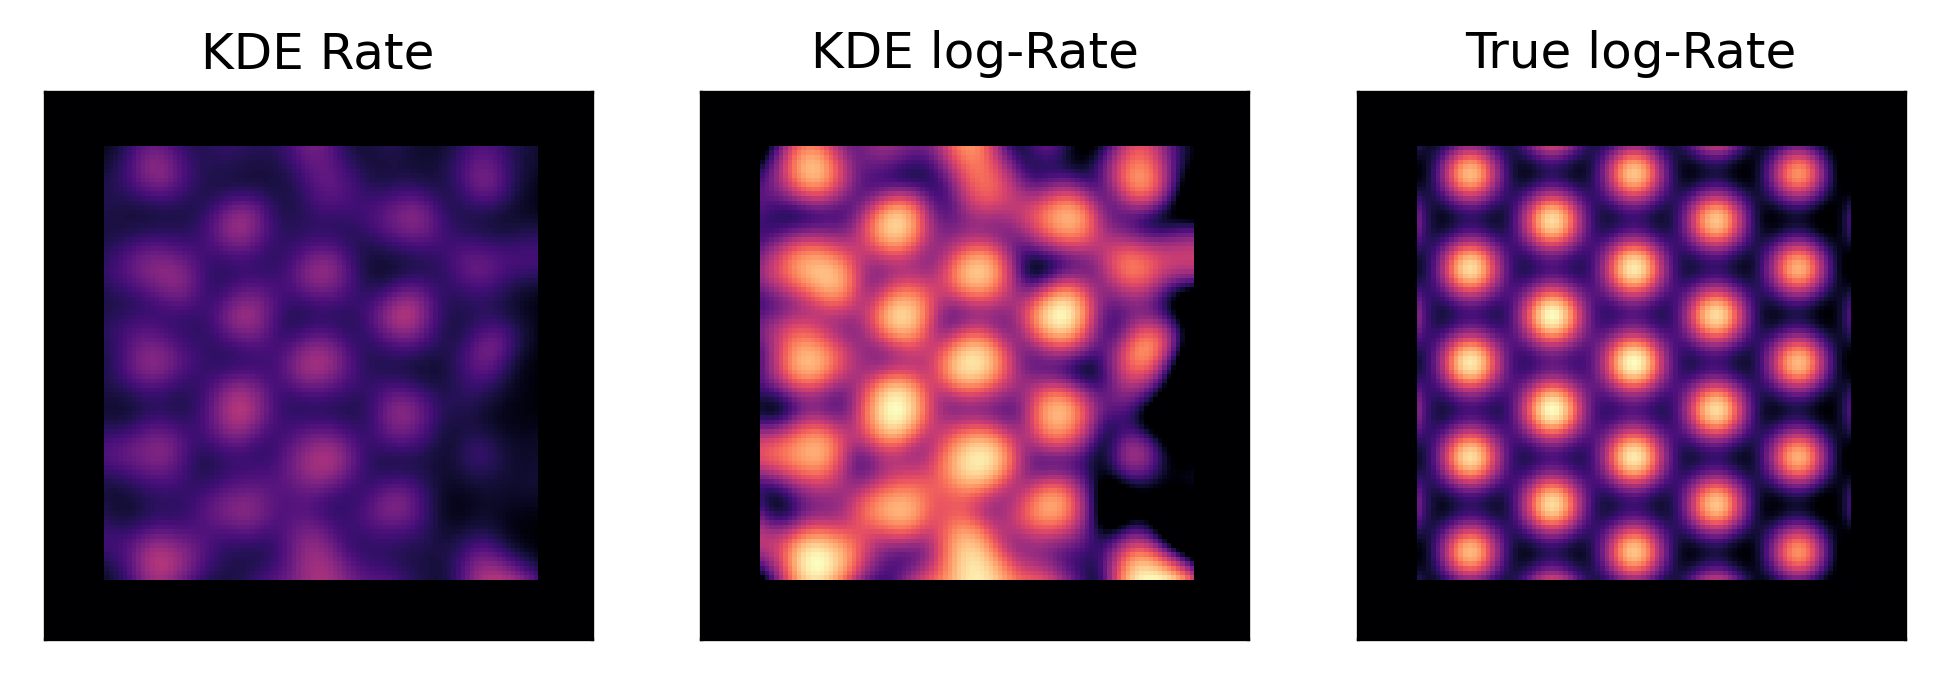

In [13]:
# define a "safe log" function
slog = lambda x:log(maximum(1e-2,x))

# Get log-rate from KDE
λhat = kdeλ(N,K,blurσ) 
lλh  = slog(λhat)

# How good are the KDE and normalized KDR estimators?
printstats(log(λ0),lλh,'KDE for log-rate')

# Calibrate prior for normalized rate
acorr = radial_acorr(lλh)
kern  = kern0*zerolag(acorr)

def pscale(x,q1=1,q2=99):
    p1 = percentile(x[mask],q1)
    p2 = percentile(x[mask],q2)
    x = clip((x-p1)/(p2-p1),0,1)
    return x*mask

subplot(131); imshow(λhat*mask,vmin=0,vmax=v1)
notic(); title('KDE Rate');
subplot(132); imshow(pscale(lλh,5,100))
notic(); title('KDE log-Rate');
subplot(133); imshow(pscale(log(maximum(1e-5,λ0)),1,100))
notic(); title('True log-Rate');

## LGCP Inference

iter  0 Δ%=270.6736
iter  1 Δ%=28.0754
iter  2 Δ%= 1.1695
iter  3 Δ%= 0.0022
LGCP, log-rate:
> Normalized MSE: 1.2%
> Pearson correlation: 0.89


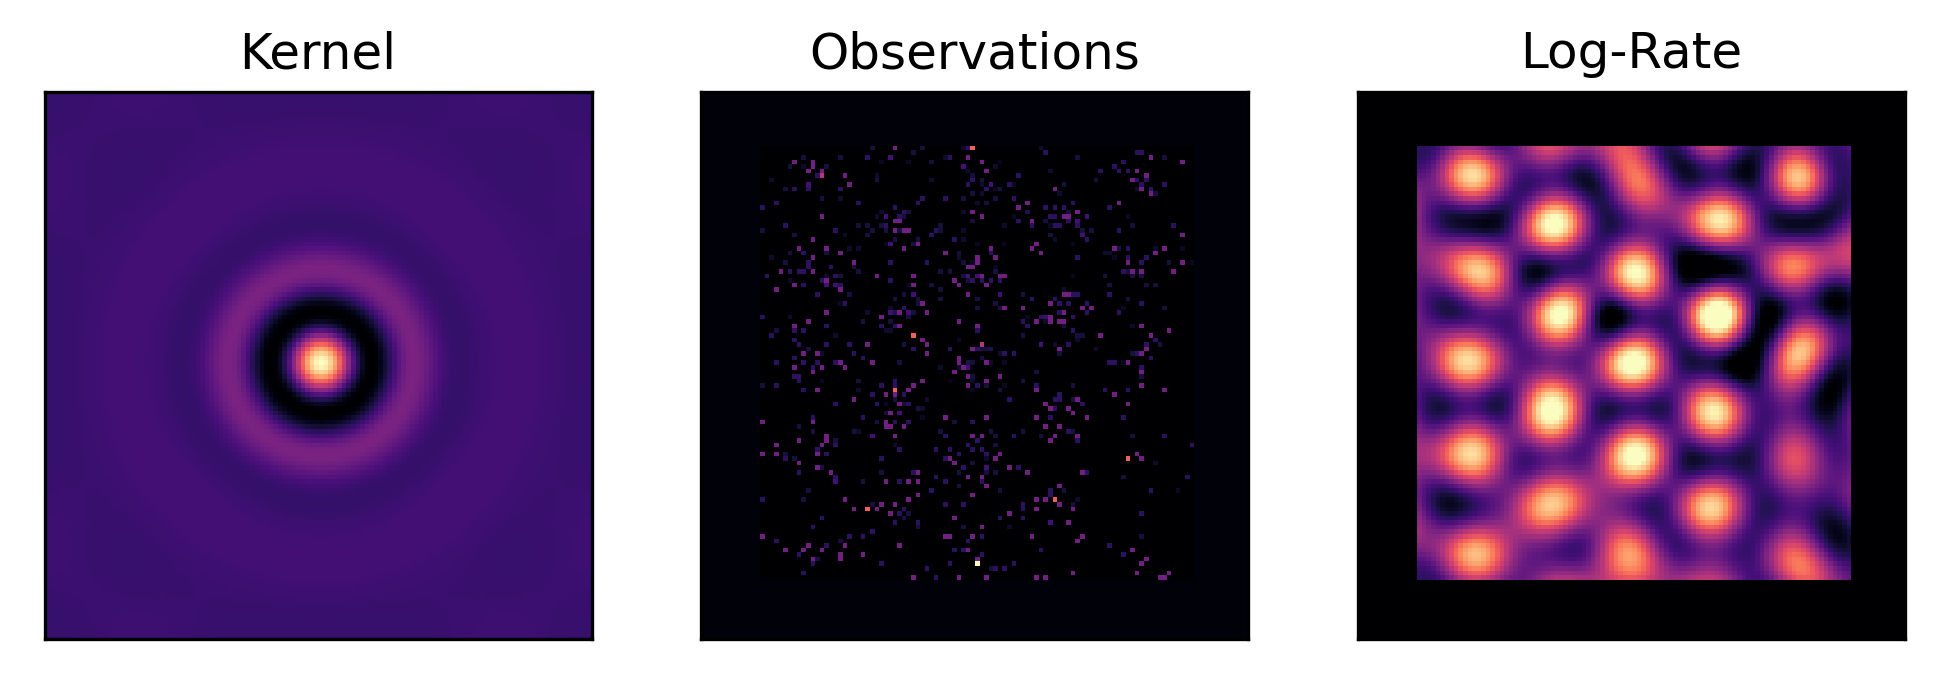

In [14]:
# Precompute variables; Passed as globals to jac/hess
n    = N.ravel()
y    = nan_to_num(K/N)
kern = repair_small_eigenvalues(kern)
Σ0   = kernel_to_covariance(kern)
kift = 1.0/fft2(kern)
kinv = real(ifft2(kift))
T0   = kernel_to_covariance(kinv)

def newton_raphson(u0,jacobian,hessian,tol=1e-2):
    # Roll-your-own Newton-Raphson
    u = array(u0)
    for i in range(10):
        H = hessian(u)
        J = jacobian(u)
        Δ = -solve(H,J).ravel()
        convergence = 100*max(abs(Δ))/mean(abs(u))
        print('iter %2d Δ%%=%7.4f'%(i,convergence))
        u += Δ
        if convergence<tol: return u
    print('Iteration did not converge')
    return u

def unpack_rate(wβ):
    wβ  = wβ.ravel()
    w,β = wβ[:-1],wβ[-1]
    return w,β,exp(w + β)

def jacobian(wβ):
    w,β,λ = unpack_rate(wβ)
    dwp = conv(w.reshape(L,L),kift).ravel()
    dwl = n*(λ-y.ravel())
    return block([dwp+dwl,sum(dwl)])

def hessian(wβ):
    w,β,λ = unpack_rate(wβ)
    nλ  = n*λ
    Hww = T0 + diag(nλ)
    Hwβ = array([nλ]).T
    Hββ = array([[sum(nλ)]])
    return block([[Hww,Hwβ],[Hwβ.T,Hββ]])

# Prepare initial guess
w0  = lλh.ravel()
β0  = mean(w0)
w0  = w0 - β0
u0  = block([array(w0),array(β0)])

# Fit model and unpack result
wβ    = newton_raphson(u0,jacobian,hessian).ravel()
w,β   = wβ[:-1],wβ[-1]
LGCP1 = w.reshape(L,L)+β

# How good is the estimator?
printstats(slog(λ0),LGCP1,'LGCP, log-rate')

subplot(131); imshow(fftshift(kern))
notic(); title('Kernel');
subplot(132); imshow(zeromean(y))
notic(); title('Observations');
subplot(133); imshow(pscale(LGCP1))
notic(); title('Log-Rate');

# Convolution approximation

We can also approximate the log-Gaussian model as a convolution. This amounts to considering only the first iteration of Newton-Raphson as if it were a GP regression problem, and replacing the per-bin measurement noise with its average. Consider a single iteration of the Newton-Raphson iteration, for the weights alone. This is: 

$$
\begin{aligned}
\mathbf w_{i+1} 
&= 
\mathbf w_{i} - [\Sigma_0^{-1} + \Sigma_\varepsilon^{-1}]^{-1} \left[
\Sigma_0^{-1} \mathbf w_{i} 
+ 
N\circ(\lambda - \tilde\lambda)
\right],
\end{aligned}
$$

where $\Sigma_\varepsilon = \operatorname{diag}[N\circ\lambda]^{-1}$. Now, approximate $\Sigma_\varepsilon\approx\sigma^2_\epsilon I$ where $\sigma^2_\epsilon=\langle(N\circ\lambda)^{-1}\rangle$ and write

$$
\begin{aligned}
\hat {\mathbf w} 
&\approx 
\mathbf w_0
 - [\Sigma_0^{-1} + \tfrac 1 {\sigma^2_\epsilon} I]^{-1} \left[
\Sigma_0^{-1} \mathbf w_{i} 
+ 
N\circ(\lambda-\tilde\lambda)
\right]
\\
&=
\mathbf w_0 
- \text F \frac {\sigma^2_\epsilon} {\tilde k+\sigma^2_\epsilon} \text F^{-1} 
\mathbf w_0 
- \text F \frac {\sigma^2_\epsilon \tilde k} {\tilde k+\sigma^2_\epsilon} \text F^{-1} 
N\circ(\lambda-\tilde\lambda)
\end{aligned}
$$

This implies an approximate solution in terms of two convolutions:

$$
\begin{aligned}
\hat {\mathbf w} 
\approx 
\mathbf w_0 
&- g\otimes\{\mathbf w_0 + \kappa\otimes[N\circ(\lambda-\tilde\lambda)]\}
\\
g(\mathbf x,\mathbf x') &= \text F^{-1} \left[ \frac {\sigma^2_\epsilon} {\tilde k+\sigma^2_\epsilon}, \right]
\end{aligned}
$$

where $\kappa(\mathbf x,\mathbf x')$ is the GP prior and $\tilde k$ is its Fourier transform. This can be calculated almost instantaneously, and differs from the MAP in this example by only a few percent.

Convolution error compared to MAP:
> Normalized MSE: 1.4%
> Pearson correlation: 0.90
Convolution log-rate estimator error:
> Normalized MSE: 1.5%
> Pearson correlation: 0.85


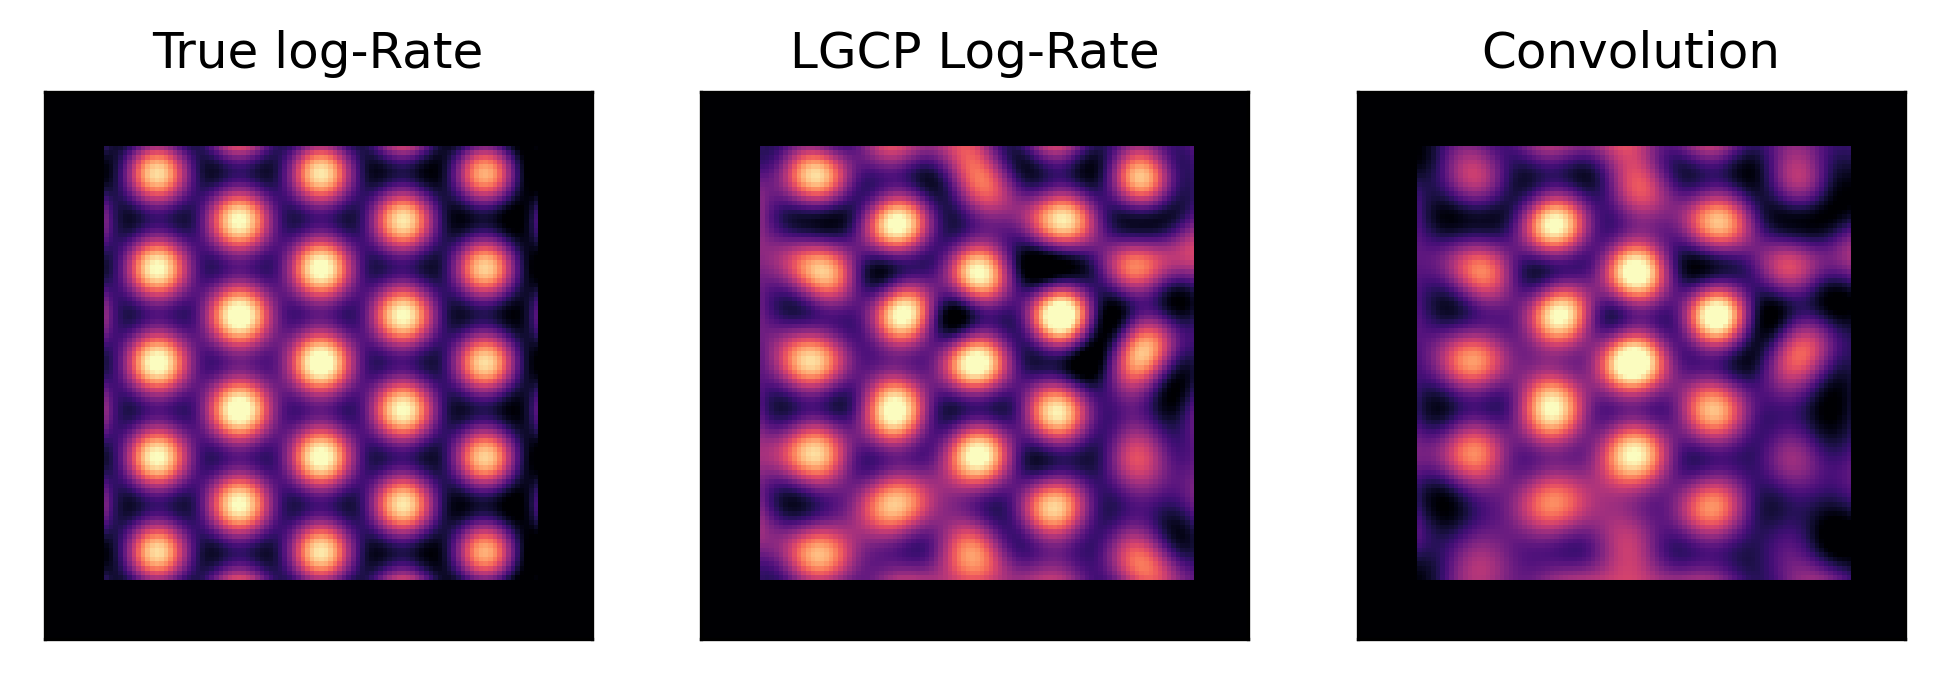

In [15]:
w0 = slog(λhat)
β0 = mean(w0[N>0])
c  = mean(1/(N*λhat)[N>0])

# Evaluate via convolution
prior_ft = fft2(kern)
kern1_ft = c/(c+prior_ft)
w2 = w0 - conv(w0 - β0 + conv(N*(λhat-y),prior_ft),kern1_ft)

printstats(LGCP1,w2,'Convolution error compared to MAP')
printstats(slog(λ0),w2,'Convolution log-rate estimator error')

subplot(131); imshow(pscale(log(maximum(1e-5,λ0))))
notic(); title('True log-Rate');
subplot(132); imshow(pscale(LGCP1))
notic(); title('LGCP Log-Rate')
subplot(133); imshow(pscale(w2))
notic(); title('Convolution');

# Subtracting the background

We can modify our log-Gaussian cox process model to subtract background rate. This is straightforward: an estimate of the background log-rate is provided as a constant offset during inference. 

iter  0 Δ%=322.7934
iter  1 Δ%=19.3987
iter  2 Δ%= 0.5413
iter  3 Δ%= 0.0003


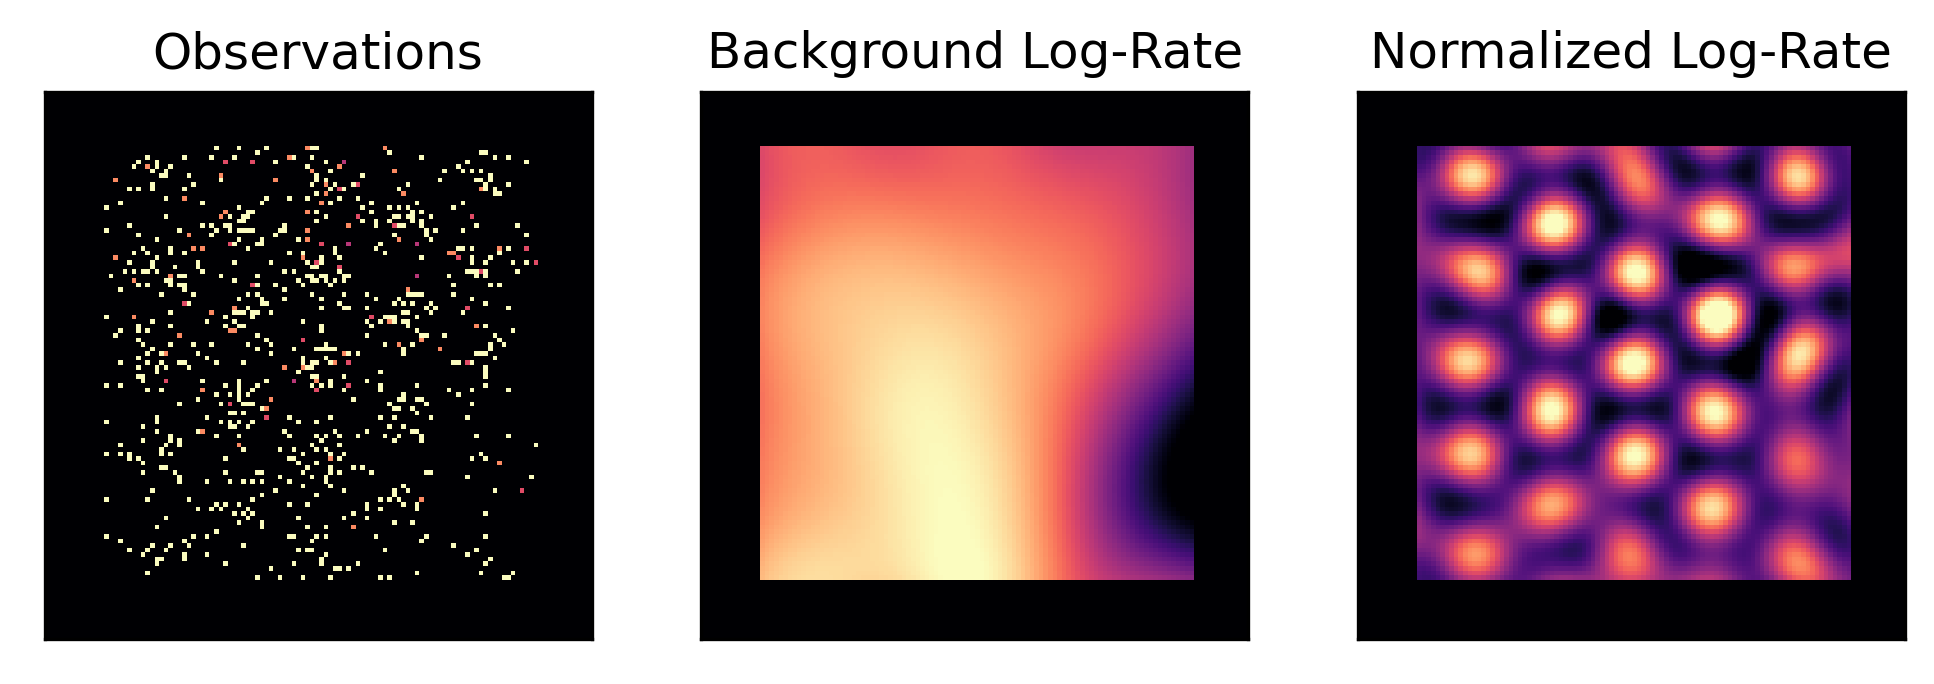

In [16]:
bgσ  = P/(2*pi)*6
λhat = kdeλ(N,K,blurσ) # Foreground rate
λbg  = kdeλ(N,K,bgσ)   # Background rate
lλh  = slog(λhat)      # Log rate
lλb  = slog(λbg)       # Log background
lλn  = lλh-lλb         # Log normalized

# Calibrate prior for normalized log rate
kern = kern0*zerolag(radial_acorr(lλn))

# Precompute variables; Passed as globals to jac/hess
n    = N.ravel()
y    = nan_to_num(K/N)
kern = repair_small_eigenvalues(kern)
Σ0   = kernel_to_covariance(kern)
kift = 1.0/fft2(kern)
kinv = real(ifft2(kift))
T0   = kernel_to_covariance(kinv)

# Change rate calculation to add log-background
def unpack_rate(wβ):
    wβ  = wβ.ravel()
    w,β = wβ[:-1],wβ[-1]
    return w,β,exp(w+β+lλb.ravel())

# Prepare initial guess
w0  = (lλh-lλb).ravel()
β0  = mean(w0)
w0  = w0 - β0
u0  = block([array(w0),array(β0)])

# Fit model and unpack result
wβ    = newton_raphson(u0,jacobian,hessian).ravel()
w,β   = wβ[:-1],wβ[-1]
LGCP2 = w.reshape(L,L)

subplot(131); imshow(y,vmin=0,vmax=v1)
notic(); title('Observations');
subplot(132); imshow(pscale(lλb))
notic(); title('Background Log-Rate')
subplot(133); imshow(pscale(LGCP2))
notic(); title('Normalized Log-Rate');

# Interim summary

So far, we have

 - Introduction:
   - Reviewed Bayesian inference for Gaussian processes 
   - Simulated spiking observations from a Hippocampal grid cell
   - Discussed estimators of spike rate in single regions
 - Smoothing approaches:
   - Used KDE smoothing to infer the underlying grid map
   - Illustrated smoothing using GP regression
   - Showed that GP smoothing is similar to KDE
   - Developed a periodic kernel for inferring grid maps using GP regression
 - Log-Gaussian Cox processes (LGCP)
   - Introduced the idea of a LGCP for for inferring log-rates
   - Derived the Jacobian and Hessian for the log-posterior of the LGCP
   - Solved for the MAP estimator of the LGCP using Newton-Raphson
   - Illustrated that the LGCP MAP estimate can be rapidly approximated via convolution
   - Shown how to subtract background rate variations in the LGCP model
 
We're almost done! By now, we have several very nice ways to smooth grid maps, many of which can leverage an assumption of underlying periodicity of the grid. Some are even fast!

# Estimating confidence intervals around peaks

One question that might be nagging you at this point is: should we believe the inferred rate maps? When we see a peak (a "grid field"), is this real, or just a noisy fluctuation? For this, it is useful generate some sort of confidence bounds or other summary of uncertainty in the inferred grid map. 


Both GP regression and LGCP model provide estimates of the posterior covariance, which encodes the uncertainty in our posterior mean (or mode). For GP regression, the covariance is

$$
\begin{aligned}
\Sigma_\text{post}
&= \left[\Sigma_0^{-1} + \Sigma_\epsilon^{-1}  \right]^{-1}
\end{aligned}
$$

For the LGCP model, we can use the Laplace approximation to model the uncertainty in our MAP estimate $\hat{\mathbf w}$. This models the posterior covariance as the inverse of the Hessian, evaluated at $\hat{\mathbf w}$. Intuitively, directions with higher curvature in our loss function are more constrained, and so have lower posterior variance. Conversely, unconstrained directions have low curvature, and therefore large posterior variance. 

$$
\begin{aligned}
\Sigma_\text{post}
&= \mathbf H_{\mathbf w}^{-1}
= \left[\Sigma_0^{-1}+\operatorname{diag}[N\circ\lambda]\right]^{-1}
\\
\lambda &= \exp( \hat{\mathbf w} + \hat \beta)
\end{aligned}
$$

Incidentally, the curvature of the observation likelihood in the LGCP model, $\operatorname{diag}[N\circ\lambda]$, is equivalent to the measurement precision $\Sigma_\epsilon^{-1}$ in GP regression. This highlights that what the LGCP model is simply finding $\lambda$ such that the observed measurement errors are consistent with a Poisson error model, $\sigma_\varepsilon^2 = \lambda$.

In these notes, GP regression inferred a posterior distribution on $\lambda$, and the LGCP model inferred a posterior distribution on $\ln\lambda$. For generality, we'll refer to both of these in terms of a generic GP posterior for function $f(\mathbf x)$, and denote $\mathbf f$ as the vector that results from to evaluating $f$ over our discrete $L\times L$ grid. 

## Using the Laplace approximation to calculate uncertainty in peak location 

The posterior covariance describes a distribution over different possible rate maps. We can denote this as the posterior mean (or mode) $mu(\mathbf x)$, plus some fluctuations $\epsilon(\mathbf x)$: 

$$
\begin{aligned}
f(\mathbf x)&=\mu(\mathbf x) + \epsilon(\mathbf x)
\\
\epsilon(\mathbf x)&\sim\mathcal{GP}\left[0,\Sigma_\text{post}(\mathbf x,\mathbf x')\right]. 
\end{aligned}
$$

The fluctuations $\epsilon(\mathbf x)$ represent the uncertainty in our smoothed rate map. We are interested in how much these fluctuations $\epsilon(\mathbf x)$ might shift a local maxima in the rate map at location $\mathbf x_0$. 

If $\mu(\mathbf x)$ is our inferred posterior mean (or mode), then a perturbation $\epsilon(\mathbf x)$ changes the rate map to $\mu(\mathbf) + \epsilon(\mathbf x)$. If perturbations are small relative to the height of out peak, they will move the inferred local maximum by an amount $\Delta \mathbf x_0$.

One can calculate $\Delta \mathbf x_0$ given $\epsilon(\mathbf x)$ by considering a second-order Taylor expansion of our rate map as a function of location $\mathbf x$. The slope is zero at $\mathbf x_0$, since we are at a local maxima. The shift $\Delta \mathbf x_0$ is therefore influences by the second-order term:

$$
\Delta \mathbf x_0 = - {\mathbf H^{\mathbf x}_\mu}^{-1}\mathbf J^{\mathbf x}_\epsilon.
$$

Above, $\mathbf J^{\mathbf x}_\epsilon = \nabla_{\mathbf x} \epsilon(\mathbf x_0)$ is the slope of our perturbation $\epsilon(\mathbf x)$ at $\mathbf x_0$. The larger this is, the more our the peak moves. The size of the shift is also controlled by the curvature of our rate map at the peak, $\mathbf H^{\mathbf x}_\mu=\nabla_{\mathbf x}\nabla_{\mathbf x}^\top\mu(\mathbf x_0)$. More curved directions shift less, i.e. sharper peaks are more difficult to move.

We are interested in summarizing the overall uncertainty in the location of a peak. This is captured by by the covariance $\Sigma_{\Delta\mathbf x_0}=\langle\Delta\mathbf x_0 (\Delta\mathbf x_0)^\top\rangle$:

$$
\begin{aligned}
\Sigma_{\Delta\mathbf x_0} 
&=\langle\Delta\mathbf x_0 (\Delta\mathbf x_0)^\top\rangle
\\&=
{\mathbf H^{\mathbf x}_\mu}^{-1}
\left< 
\mathbf J^{\mathbf x}_\epsilon
{\mathbf J^{\mathbf x}_\epsilon}^\top
\right>
{\mathbf H^{\mathbf x}_\mu}^{-1}
\\&=
{\mathbf H^{\mathbf x}_\mu}^{-1}
\left< 
\nabla_{\mathbf x} 
\epsilon(\mathbf x_0)
\epsilon(\mathbf x_0)^\top
\nabla_{\mathbf x}^\top
\right>
{\mathbf H^{\mathbf x}_\mu}^{-1}
\\&=
{\mathbf H^{\mathbf x}_\mu}^{-1}
\left[ \nabla_{\mathbf x} \Sigma(\mathbf x_0,\mathbf x_0) \nabla_{\mathbf x}^\top \right]
{\mathbf H^{\mathbf x}_\mu}^{-1}
\end{aligned}
$$

In our analyses, we evaluate the posterior mean and covariance on an $L\times L$ grid. Peaks in the posterior mean or mode be identified as local maxima in this grid.

The term $\nabla_{\mathbf x} \Sigma(\mathbf x_0,\mathbf x_0) \nabla_{\mathbf x}^\top$ reflects the distribution of the  gradient of our rate map at $\mathbf x_0$. This can be calculated numerically, by constructing the linear operators for the discrete derivative in each direction of our coordinates $\mathbf x$. These derivative operators are simply vectors ${\mathbf d^{x_i}_{\mathbf x_0}}$ such that

$$
{\mathbf d^{x_i}_{\mathbf x_0}}^\top\mathbf f\approx\partial_{x_i}f(\mathbf x)\Bigr|_{\mathbf x_0},
\qquad
\nabla_{\mathbf x}
=
\begin{bmatrix}
{\mathbf d^{x_1}_{\mathbf x_0}}&
{\mathbf d^{x_2}_{\mathbf x_0}}
\end{bmatrix}^\top
$$

Similarly, the curvature at our peak can be calculated as $\mathbf H^{\mathbf x}_\mu=\nabla_{\mathbf x}\nabla_{\mathbf x}^\top\mu(\mathbf x_0)$.

For larger problems, it may not be practical to store the full posterior covariance in memory. However, the above vector-matrix products can be solved by re-phrasing them as linear systems, and solving these systems with gradient descent.  The inverse of the posterior variance is the sum of the kernel, which can be applied to a vector as a convolution via FFT, and a diagonal matrix of observation errors, which can also be represented compactly. 

In [17]:
from scipy.stats import chi2

def findpeaks(q,th=-inf,r=1):
    '''
    Find points higher than threshold th, that are also higher
    than all other points in a square neighborhood with radius r. 
    '''
    L  = q.shape[0]
    D  = 2*r
    Δ  = range(D+1)
    q0 = q[r:-r,r:-r,...]
    p  = q0>th
    for i,j in {(i,j) for i in Δ for j in Δ if i!=r or j!=r}:
        p &= q0>q[i:L+i-D,j:L+j-D,...]
    p2 = zeros(q.shape,bool)
    p2[r:-r,r:-r,...] = p
    return p2

def covariance_crosshairs(S,p=0.8):
    # Generate a collection of (x,y) lines denoting the confidence 
    # bound for p fraction of data from 2D covariance matrix S
    sigma  = chi2.isf(1-p,df=2)
    e,v    = eigh(S)
    lines  = list(exp(1j*linspace(0,2*pi,181)))
    lines += [nan]+list(   linspace(-1,-.2,5))
    lines += [nan]+list(1j*linspace(-1,-.2,5))
    lines += [nan]+list(   linspace(.2,.95,5))
    lines += [nan]+list(1j*linspace(.2,.95,5))
    lines = array(lines)
    lines = array([lines.real,lines.imag])*sigma*(e**0.5)[:,None]
    return solve(v,lines)

def dx_op(L):
    # 2D difference operator in the 1st coordinate
    dx = zeros((L,L))
    dx[0, 1]=-.5
    dx[0,-1]= .5
    return dx

def hessian_2D(q):
    # Get Hessian at all points
    dx  = dx_op(q.shape[0])
    f1  = fft2(dx)
    f2  = fft2(dx.T)
    d11 = conv(q,f1*f1)
    d12 = conv(q,f2*f1)
    d22 = conv(q,f2*f2)
    return array([[d11,d12],[d12,d22]]).transpose(2,3,0,1)

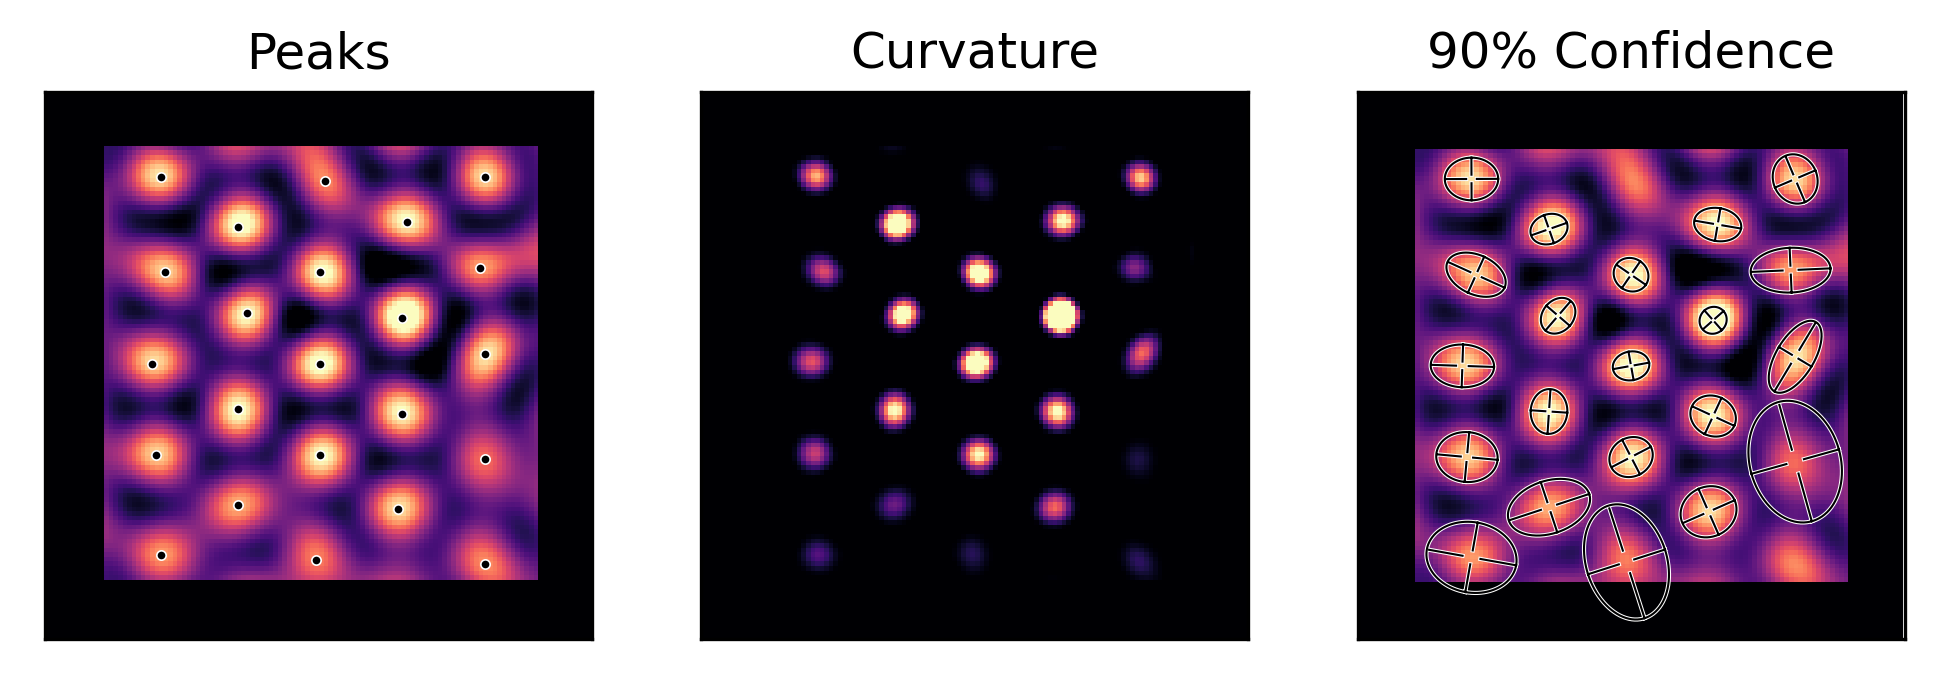

In [18]:
# Get posterior hessian
H = hessian(wβ)[:-1,:-1]
D = chol(H)

# Get Hessian at all points
dx = dx_op(L)
q  = LGCP2
Hx = hessian_2D(q)
Dx = det(Hx)

# Find peaks
pxy = array(where(findpeaks(q.T)*mask))

subplot(131)
imshow(pscale(q));
scatter(*pxy,s=5,facecolor='k',edgecolor='w',lw=0.4)
notic(); title('Peaks')

subplot(132)
imshow(pscale(maximum(0,Dx*maximum(0,q))))
notic(); title('Curvature')

from scipy.linalg import solve_triangular as stri

def plot_peakbounds(pxy,Hx,D,P):
    # D should be the cholesky factor of the Hessian of the log-posterior
    lx,ly = [],[]
    for x2,x1 in pxy.T:
        # Jacobian at x0
        Δx1 = roll(dx  ,(x1,x2),(0,1))
        Δx2 = roll(dx.T,(x1,x2),(0,1))
        J   = array([Δx1,Δx2]).reshape(2,L**2)
        # Peak location confidence
        vv  = stri(D.T,J.T,lower=True).T
        Ux0 = solve(Hx[x1,x2],vv)
        Σx0 = Ux0@Ux0.T
        # Plot if peak is acceptably localized
        if max(eigh(Σx0)[0])<P*0.5:
            cx,cy = covariance_crosshairs(Σx0,p=0.9)
            lx += [nan] + list(cx+x2)
            ly += [nan] + list(cy+x1)
    plot(lx,ly,color='w',lw=1.0)
    plot(lx,ly,color='k',lw=0.5)
    notic(); title('90% Confidence');
    xlim(0,L); ylim(0,L)

# Compute confidence elipses
subplot(133); 
imshow(pscale(q))
plot_peakbounds(pxy,Hx,D,P);

## Use sampling to assess the probability of a peak

Another approach to characterizing uncertainty is to simply sample from the posterior distribution, and test how many of these samples have a certain property, for example, having a peak at location $\mathbf x_0$. This is impractical for larger problems, but can work surprisingly well on modern hardware, even for a grid size of $L=100$, which has a covariance matrix with $10^8$ entries.

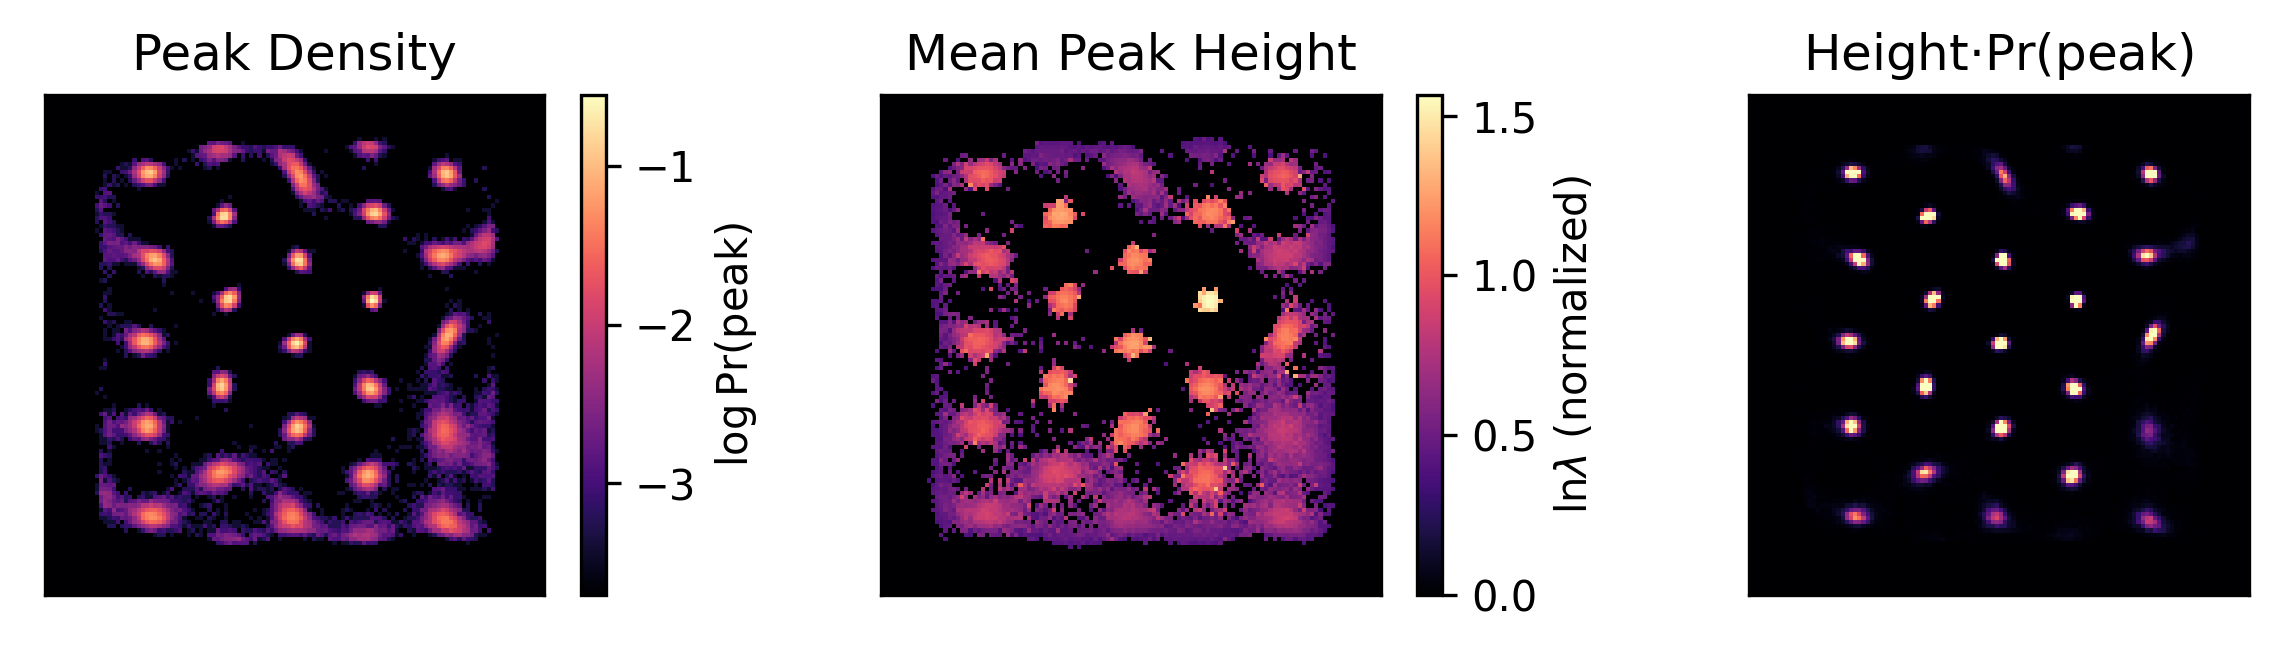

In [19]:
softmask = blur(mask,5,normalize=True)

def peak_density(w,D,Niter=5000):
    # w: posterior mean or mode vector
    # D: cholesky factor of the Hessian of the log-posterior
    q = stri(D,randn(L**2,Niter))
    q = (q+w.ravel()[:,None]).reshape(L,L,Niter)
    q = (q-mean(mean(q,2)[mask]))*softmask[:,:,None]
    peaks = findpeaks(q,th=std(q))
    dnsty = mean(peaks,axis=2)
    μhght = nan_to_num(sum(q*peaks,2)/sum(peaks,2))
    return dnsty,μhght

dnsty,μhght = peak_density(w,D)
dnsty = maximum(1/5000,dnsty)

subplot(131)
imshow(log10(dnsty))
notic(); title('Peak Density')
colorbar(label='$\log\,\Pr(\operatorname{peak})$')

subplot(132)
imshow(μhght)
notic(); title('Mean Peak Height')
colorbar(label='$\ln\lambda$ (normalized)')

subplot(133)
imshow(pscale(μhght*dnsty))
notic(); title('Height$\cdot\Pr$(peak)')

tight_layout()
subplots_adjust(left=0,right=1,bottom=0.2,wspace=0.15);

# Putting it all together

Starting from the beginning, a fast(ish) way to analyze grid cell rate maps is to

 - Bin spikes into a histogram of total spikes $K$ and visits $N$ to each region
 - Use autocorrelation to estimate the grid scale
 - Use an idealized grid to set a prior for the log rate
 - Infer log-rate using kernel density estimation, use this as an initializer
 - Heuristically fit a log-Gaussian Cox process model using convolution
 - Summarize the confidence in the inferred grid peaks

Δt=6ms     Calibrated grid
Δt=3ms     Ran kernel density estimate
Δt=8ms     Prepared prior kernel
Δt=2ms     Convolution heuristic LGCP
Δt=1092ms  Built prior precision
Δt=14768ms Cholesky decomposition of posterior precision
Δt=2148ms  Peak density
Δt=6471ms  Plot peak confidence


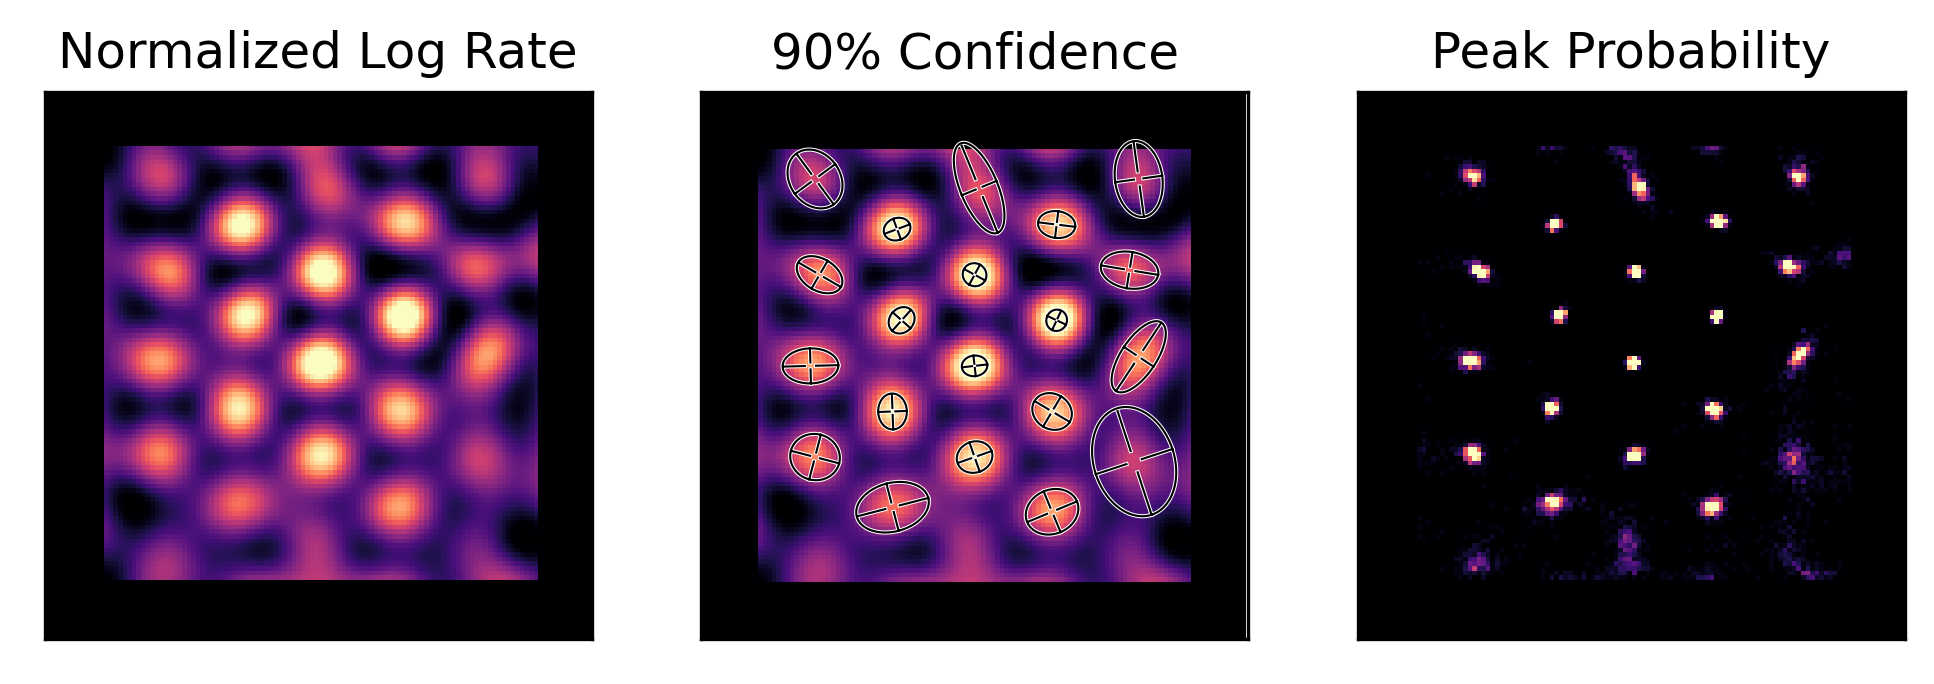

In [20]:
# Timer routine to track performance
import time
tictime = None
def tic(msg=''):
    global tictime
    t = time.time()*1000
    if tictime and msg:
        print(('Δt=%dms'%(t-tictime)).ljust(11)+msg)
    tictime = t

# Calibrate grid scale
tic()
λhat  = kdeλ(N,K,1.5)
λbg   = kdeλ(N,K,blurσ*2) 
acor2 = fft_acorr(λhat)
acorR = radial_average(acor2)
P     = np.min(find_peaks(acorR[L//2+2:])[0])+1
blurσ = P/pi
tic('Calibrated grid')

# Get log-rate from KDE
λhat  = kdeλ(N,K,blurσ) 
lλh   = slog(λhat)
λbg   = kdeλ(N,K,blurσ*2) 
lλbg  = slog(λbg)
tic('Ran kernel density estimate')

# Make symmetric kernel from autocorrelation of ideal grid
grid  = ideal_hex_grid(L,P)
axR   = radial_acorr(grid)
kernR = radial_kernel(axR)
nadir = where(axR[L//2:]<0)[0]
limit = np.min(negative[negative>P])
win   = fftshift(abs(coords)<limit)
kern0 = kernR*win
kern0 = blur(kern0,blurσ)
kern0 = kern0/np.max(kern0)
kern  = kern0*zerolag(radial_acorr(lλh))
kern  = repair_small_eigenvalues(kern)
tic('Prepared prior kernel')

# Evaluate via convolution
w0 = lλh-lλbg
β0 = mean(w0[N>0])
w0 = w0-β0
τ  = N*λhat
c  = mean(1/τ[N>0])
kf = fft2(kern)
gf = c/(c+prior_ft)
w2 = w0 - conv(w0 + conv(N*(λhat-y),kf), gf)
tic('Convolution heuristic LGCP')

# Precompute variables; Passed as globals to jac/hess
kift = 1.0/fft2(kern)
kinv = real(ifft2(kift))
T0   = kernel_to_covariance(kinv)
tic('Built prior precision')

# Estimate posterior variance
H = T0 + diag(τ.ravel())
D = chol(H)
tic('Cholesky decomposition of posterior precision')

density = peak_density(w2,D,500)[0]
tic('Peak density')

# Plot inferred map
subplot(131)
imshow(pscale(w2))
notic(); title('Normalized Log Rate')

# Compute confidence elipses
subplot(132)
imshow(pscale(w2))
tic()
Hx  = hessian_2D(w2)
pxy = array(where(findpeaks(w2.T)*mask))
plot_peakbounds(pxy,Hx,D,P)
tic('Plot peak confidence')

# Compute peak density
subplot(133)
imshow(pscale(density))
notic(); title('Peak Probability');

# Overall,

Congratulations! You might be the first reader to make it the end of these notes. Overall, we illustrated several approaches to Gaussian-process regression to Hippocampal grid cell data. We covered kernel density estimation, Gaussian process regression, and log-Gaussian Cox process regression. Throughout, we discussed practical issues necessary to achieve good performance, like using the FFT when possible, choosing numerically stable forms of the equations, and fast approximations based on convolution. 

Ultimately, we derived an exceptionally fast FFT-based approximation to log-Gaussian Cox process regression: regression is nearly instantaneous, and computation time is dominated by calculating confidence intervals from the approximate posterior. This provides an approach to analyzing Hippocampal grid cell data that is both statistically and computationally efficient.